# <a id='toc1_'></a>[Cross-Selling of Credit Cards](#toc0_)
- **Author**: Nils Fahrni
- **Date**: 14. June 2024

**Table of contents**<a id='toc0_'></a>    
- [Cross-Selling of Credit Cards](#toc1_)    
  - [Data Overview](#toc1_1_)    
  - [Data Preprocessing](#toc1_2_)    
    - [Data Loading](#toc1_2_1_)    
      - [Account](#toc1_2_1_1_)    
      - [Client](#toc1_2_1_2_)    
      - [Disposition](#toc1_2_1_3_)    
      - [Permanent Order](#toc1_2_1_4_)    
      - [Transaction](#toc1_2_1_5_)    
      - [Loan](#toc1_2_1_6_)    
      - [Credit Card](#toc1_2_1_7_)    
      - [District](#toc1_2_1_8_)    
    - [Data Merging](#toc1_2_2_)    
    - [Data Cleaning](#toc1_2_3_)    
      - [Removing Junior Cards](#toc1_2_3_1_)    
  - [Model Construction](#toc1_3_)    
    - [Processing Transactional Data](#toc1_3_1_)    
    - [Defining Roll-Up Windows of Transactions](#toc1_3_2_)    
    - [Validating Negative Examples](#toc1_3_3_)    
      - [Pivoting the transactions](#toc1_3_3_1_)    
    - [Bringing the data together](#toc1_3_4_)    
  - [Exploratory Data Analysis](#toc1_4_)    
    - [Exploring Missing Values](#toc1_4_1_)    
    - [Cardholders vs Non-Cardholders](#toc1_4_2_)    
    - [ Card Types](#toc1_4_3_)    
    - [Distribution of Issuance Dates](#toc1_4_4_)    
    - [Balance and Volume over time](#toc1_4_5_)    
    - [Volume before card purchase](#toc1_4_6_)    
    - [Age distribution](#toc1_4_7_)    
  - [Feature Engineering](#toc1_5_)    
    - [Demographic-Based Features](#toc1_5_1_)    
      - [Defining Age Groups](#toc1_5_1_1_)    
      - [Age at loan](#toc1_5_1_2_)    
      - [Account age](#toc1_5_1_3_)    
    - [Financial Features](#toc1_5_2_)    
      - [Average Monthly Payment Ratio](#toc1_5_2_1_)    
    - [District Features](#toc1_5_3_)    
      - [Client-Account Region Match](#toc1_5_3_1_)    
      - [District Population Density](#toc1_5_3_2_)    
    - [Event-Based Statistics](#toc1_5_4_)    
    - [Looking at the effect of the new features](#toc1_5_5_)    
      - [Impact of variance](#toc1_5_5_1_)    
      - [Looking at temporal client traits](#toc1_5_5_2_)    
  - [Train-Test-Split](#toc1_6_)    
  - [Baseline Model](#toc1_7_)    
  - [Further Model Candidates](#toc1_8_)    
    - [Logistic Regression](#toc1_8_1_)    
    - [Decision Tree](#toc1_8_2_)    
    - [Random Forest](#toc1_8_3_)    
    - [Bagging](#toc1_8_4_)    
    - [Boosting](#toc1_8_5_)    
  - [Comparing the Model Candidates](#toc1_9_)    
    - [ROC Curves](#toc1_9_1_)    
    - [Confusion Matrices](#toc1_9_2_)    
    - [Other Metrics](#toc1_9_3_)    
    - [Top Customer Lists](#toc1_9_4_)    
    - [Choosing a Final Model](#toc1_9_5_)    
  - [Model Reduction](#toc1_10_)    
    - [Selecting Features](#toc1_10_1_)    
  - [Model Explanation](#toc1_11_)    
    - [Evaluation Metrics](#toc1_11_1_)    
    - [Variable Importance](#toc1_11_2_)    
    - [Partial Dependence](#toc1_11_3_)    
    - [Variable Attribution](#toc1_11_4_)    
  - [Conclusive Value of the Final Model](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import warnings
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

plt.style.use('ggplot')

pio.templates.default = 'ggplot2'
pio.renderers.default = "notebook"
pd.set_option('display.max_columns', None)

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

np.random.seed(1337)

sys.path.append(parent_dir)

## <a id='toc1_1_'></a>[Data Overview](#toc0_)

![Entity Relationship Diagram](images/erd.png)

## <a id='toc1_2_'></a>[Data Preprocessing](#toc0_)

In the following section the goal is to load in all artifacts from the PKDD'99 Dataset and to merge them together into a single dataframe that will allow for further processing steps.

### <a id='toc1_2_1_'></a>[Data Loading](#toc0_)

To load the PKDD'99 Dataset, a `DataLoader` class was created to streamline the onloading process. The dataset already has a few structural flaws, such as the dates being represented as `YYMMDD`, so just a single integer number. The `DataLoader` object takes care of this flaw and imports all date columns in actual datetype formats. This will later on allow for simpler date-specific operations and interpretation.

Another task that the `DataLoader` takes on is the translation. The PKDD'99 Dataset stems from a Czech bank which means that a lot of column names and categorical values are in Czech language. To tranlsate these columns and their values into English, a `translation_mappings.json` file inside the `/data` directory was created. This JSON file helps to control which values and attributes need to get translated and their respective new name. The file can be passed into the `DataLoader`, resulting in new translated names among all variables.

In [2]:
from src.data_utils import DataLoader

data_loader = DataLoader(base_path='data', translations_name='translation_mappings.json')
data_loader.list_datasets()

Dataset  Number of Rows
0      loan             682
1    client            5369
2  district              77
3     trans         1056320
4   account            4500
5      card             892
6     order            6471
7      disp            5369

To make sure everything will get loaded correctly, the instantiated `data_loader` object has a `list_datasets()` method which yields a glimpse of the `.csv`-files inside the `/data` directory.

#### <a id='toc1_2_1_1_'></a>[Account](#toc0_)

First, the Accounts will get loaded in. As can be seen in the Entity Relationship Diagram, this table is the centerpiece of all the relations inside the dataset. As already touched upon, the date variables are represented as 6-digit integers inside the `.csv` files. This will get addressed during the loading process. For this a date parsing pattern gets passed into the function so that we can interpret the unformatted parts of the integers and convert them into the corresponding time piece (year, month and day).

In [3]:
account = data_loader.load_csv('account', parse_dates={'date': '%y%m%d'})
account.sample(5)

Mapped frequency:
{
    "POPLATEK MESICNE": "MONTHLY CHARGES",
    "POPLATEK TYDNE": "WEEKLY CHARGES",
    "POPLATEK PO OBRATU": "TRANSACTION CHARGES"
}


account_id  district_id        frequency       date
2103        3646           63   WEEKLY CHARGES 1995-10-20
1721         981           66  MONTHLY CHARGES 1995-03-25
1193        2501           30  MONTHLY CHARGES 1994-02-26
2892        2604           68  MONTHLY CHARGES 1996-07-04
252         1189           59  MONTHLY CHARGES 1993-03-19

The sample shows that the translation mappings also got correctly applied, the frequency column was translated correctly into english.

#### <a id='toc1_2_1_2_'></a>[Client](#toc0_)

The next table is the client `.csv`. It also has multiple relations: Once to the Dispositions and once to the Districts.

Inside the client table there also was a special remark: The `birth_number` variable has the sex of each client encoded. The male "birth numbers" are just date integers as we already noticed in the first section. The female birth numbers however have an added **50 days** on each date integer. Since sex/gender could also be of value to us later on, the birthdates get "fixed" by turning them both into regular datetime values. Additionally the gender will be written into another column based on if the day-part of the date integer is greater or lower than 50. The birthdate also allows us to directly extract the age of the clients in year, so an age column gets added by subtracting the birthdate from a proposed "key date" which is 1999-12-31. Of course in a real-world scenario this date would be the current date and not some arbituary past date.

In [4]:
client = data_loader.load_csv('client')

client = client.assign(gender=client['birth_number'].apply(lambda x: 'FEMALE' if int(str(x)[2:4]) > 50 else 'MALE'))

client = client.assign(birth_number=client.apply(lambda x: x['birth_number'] - 5000 if x['gender'] == 'FEMALE' else x['birth_number'], axis=1))

client['birth_number'] = pd.to_datetime(client['birth_number'], format='%y%m%d')
client['birth_date'] = client['birth_number'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 1999 else x)
client.drop('birth_number', axis=1, inplace=True)

client['age'] = (pd.to_datetime('1999-12-31') - client['birth_date']).dt.days // 365

client.sample(5)

client_id  district_id  gender birth_date  age
4105       4336           19  FEMALE 1969-08-02   30
2112       2229           68    MALE 1944-09-07   55
1463       1547           28  FEMALE 1927-12-20   72
3951       4177           34    MALE 1935-12-25   64
3835       4052           74  FEMALE 1950-10-17   49

The sample shows that the dates got formatted correctly and our two new columns (gender and age) have been added correctly. Within this table no translations were needed, hence no translation-mapping output.

#### <a id='toc1_2_1_3_'></a>[Disposition](#toc0_)

The disposition table holds information on which clients have the "right" to issue permanent orders and ask for a loan. The owners of each account are marked as "OWNER". Other users relations to an account are marked as "DISPONENT".

It is assumed that only account owners would have the right to make a permanent order like buying a new card, hence the decision was made to remove non-owners (disponents). Disponents may be secondary users that have been authorized to use an account. They may be allowed to execute transactions on that account but they are not the authorized owners.

In [5]:
disp = data_loader.load_csv('disp')

disp = disp[disp['type'] != 'DISPONENT']

disp.drop('type', axis=1, inplace=True)

disp.sample(5)

disp_id  client_id  account_id
4478     4737       4737        3928
5044     9512       9820        7944
3781     3994       3994        3302
1450     1531       1531        1269
1439     1520       1520        1259

#### <a id='toc1_2_1_4_'></a>[Permanent Order](#toc0_)

A permanent order record describes an order made between two accounts; The `account_id` (sender) sends `amount` to `account_to` (beneficiary) at bank `bank_to`. Each can also be marked with a k_symbol (type of payment).

In [6]:
order = data_loader.load_csv('order')

order.sample(5)

Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SIPO": "HOUSEHOLD",
    "LEASING": "LEASING",
    "UVER": "LOAN PAYMENT"
}


order_id  account_id bank_to  account_to   amount           k_symbol
5126     35080        3854      QR    36950737   1290.0          HOUSEHOLD
2680     32349        2016      ST    81232386    157.0  INSURANCE PAYMENT
403      29843         291      YZ    27026367  12925.0                NaN
5868     40382        7437      EF     2692229   6901.0          HOUSEHOLD
5952     41067        7861      OP    58806037    400.0                NaN

Here, the sample shows that the `k_symbol` column got translated correctly.

It seems that not every order has a labeled type of payment. To validate this observation we will take a closer look at orders with an undefined `k_symbol`.

In [7]:
display(order.isnull().sum())

display(order[order['k_symbol'].isnull()].sample(5))

order_id         0
account_id       0
bank_to          0
account_to       0
amount           0
k_symbol      1379
dtype: int64

order_id  account_id bank_to  account_to  amount k_symbol
2746     32417        2057      YZ     1773274   970.0      NaN
69       29475          48      ST     2071685  1029.0      NaN
6420     45778       11013      IJ    43103534  9499.0      NaN
1788     31375        1342      ST    45400208  1011.0      NaN
2847     32533        2139      GH    92438989  4737.0      NaN

The other variables do not show additional abnormality so it can be concluded that the `k_symbol` is not a mandatory field for every order.

To still keep the information of these undefined orders a "MISSING" label will get added. 

The orders contain granular information on which account forwarded money to another bank/recipient. To build a client summary at the end these orders need to get compressed into valuable information which can be assigned to a client - Therefore, the `k_symbol` gets pivoted and for each order a count is added to the respective order type. 

In [8]:
order['k_symbol'] = order['k_symbol'].fillna('MISSING')

order_pivot = order.pivot_table(index='account_id', columns='k_symbol', values='amount', aggfunc='count', fill_value=0)

order_pivot.sample(5)

k_symbol    HOUSEHOLD  INSURANCE PAYMENT  LEASING  LOAN PAYMENT  MISSING
account_id                                                              
552                 1                  0        0             0        0
198                 2                  0        0             0        0
578                 1                  1        0             0        2
1583                0                  0        0             1        0
226                 1                  0        0             1        0

#### <a id='toc1_2_1_5_'></a>[Transaction](#toc0_)

The transactions seem to be fairly similar to the orders. They also get categorized by a `k_symbol` attribute. This category's values should therefore also be translated.

In [9]:
transaction = data_loader.load_csv('trans', parse_dates={'date': '%y%m%d'})

transaction.sample(5)

Mapped type:
{
    "PRIJEM": "CREDIT",
    "VYDAJ": "WITHDRAWAL"
}
Mapped operation:
{
    "VYBER KARTOU": "CREDIT CARD WITHDRAWAL",
    "VKLAD": "CREDIT IN CASH",
    "PREVOD Z UCTU": "COLLECTION FROM ANOTHER BANK",
    "VYBER": "WITHDRAWAL IN CASH",
    "PREVOD NA UCET": "REMITTANCE TO ANOTHER BANK"
}
Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SLUZBY": "PAYMENT FOR STATEMENT",
    "UROK": "INTEREST CREDITED",
    "SANKC. UROK": "SANCTION INTEREST IF NEGATIVE BALANCE",
    "SIPO": "HOUSEHOLD",
    "DUCHOD": "OLD-AGE PENSION",
    "UVER": "LOAN PAYMENT"
}


trans_id  account_id       date        type  \
926595    3444421        3223 1998-07-31      CREDIT   
715788     134286         450 1997-12-12      CREDIT   
673209    3564940        1046 1997-10-31      CREDIT   
776368     204567         694 1998-01-31  WITHDRAWAL   
1028116   3600996        2141 1998-11-30      CREDIT   

                            operation  amount  balance               k_symbol  \
926595                            NaN    92.9  14640.3      INTEREST CREDITED   
715788   COLLECTION FROM ANOTHER BANK  4393.0  16076.3        OLD-AGE PENSION   
673209                            NaN   130.1  27631.5      INTEREST CREDITED   
776368             WITHDRAWAL IN CASH    14.6  29151.1  PAYMENT FOR STATEMENT   
1028116                           NaN   283.4  70926.4      INTEREST CREDITED   

        bank     account  
926595   NaN         NaN  
715788    AB  94329887.0  
673209   NaN         NaN  
776368   NaN         NaN  
1028116  NaN         NaN

#### <a id='toc1_2_1_6_'></a>[Loan](#toc0_)

The loan table holds records of the loans given out to certain accounts. It contains the loan amount, the duration of it in months, the monthly interest (payments) and a status. 

The status is a categorical variable which gets mapped to some clearer status descriptions.

In [10]:
loan = data_loader.load_csv('loan', parse_dates={'date': '%y%m%d'})

loan.sample(5)

Mapped status:
{
    "A": "contract finished, no problems",
    "B": "contract finished, loan not payed",
    "C": "running contract, OK so far",
    "D": "running contract, client in debt"
}


loan_id  account_id       date  amount  duration  payments  \
629     5015         226 1998-07-12  109344        12    9112.0   
323     6818        9030 1996-12-12  155616        48    3242.0   
670     6168        5698 1998-11-21   99216        36    2756.0   
407     6278        6265 1997-06-10   87360        24    3640.0   
27      5189        1166 1994-02-07  149040        48    3105.0   

                             status  
629     running contract, OK so far  
323     running contract, OK so far  
670     running contract, OK so far  
407     running contract, OK so far  
27   contract finished, no problems

According to the Entity Relationship Diagram, an account can in theory have multiple loans. If an account has multiple loans that would make the preprocessing a bit harder since we cannot match a loan 1:1 into a summarizing table. Therefore, a first check would be to look if there are multiple loans for a given account:

In [11]:
print(f'Are there accounts with multiple loans: {loan["account_id"].nunique() < loan.shape[0]}')

Are there accounts with multiple loans: False


The check yielded that there are only unique accounts for all loans, so no account has more than one loan.

#### <a id='toc1_2_1_7_'></a>[Credit Card](#toc0_)

The credit card table holds all information on which card is held by which owner/account through the disposition interim table. It also holds information on the card `type`. The card types are already branded in english so no translational mapping needs to be made.

In [12]:
card = data_loader.load_csv('card', parse_dates={'issued': '%y%m%d'})

card.sample(5)

card_id  disp_id     type     issued
159      854     6753  classic 1996-10-07
205      137      786   junior 1997-01-10
445      481     3102   junior 1998-01-06
350       19      130  classic 1997-09-09
533      510     3256  classic 1998-04-13

#### <a id='toc1_2_1_8_'></a>[District](#toc0_)

The district table contains information on the domicile of the accounts and the domicil of the clients.

This table has numerous variables with id-like names. These need to get renamed for clarity:

In [13]:
district = data_loader.load_csv('district')

district = district.rename(columns={
    'A1': 'district_id',
    'A2': 'district_name',
    'A3': 'region',
    'A4': 'population',
    'A5': 'n_municipalities_with_inhabitants_lt_499',
    'A6': 'n_municipalities_with_inhabitants_500_to_1999',
    'A7': 'n_municipalities_with_inhabitants_2000_to_9999',
    'A8': 'n_municipalities_with_inhabitants_gt_10000',
    'A9': 'n_cities',
    'A10': 'ratio_urban_inhabitants',
    'A11': 'average_salary',
    'A12': 'unemployment_rate_95',
    'A13': 'unemployment_rate_96',
    'A14': 'enterpreneurs_per_1000_inhabitants',
    'A15': 'n_commited_crimes_95',
    'A16': 'n_commited_crimes_96'
})

district.sample(5)

district_id  district_name         region  population  \
70           71     Novy Jicin  north Moravia      161227   
72           73          Opava  north Moravia      182027   
75           76        Sumperk  north Moravia      127369   
25           26  Plzen - mesto   west Bohemia      170449   
55           56        Breclav  south Moravia      124605   

    n_municipalities_with_inhabitants_lt_499  \
70                                         5   
72                                        17   
75                                        31   
25                                         0   
55                                        11   

    n_municipalities_with_inhabitants_500_to_1999  \
70                                             35   
72                                             49   
75                                             32   
25                                              0   
55                                             42   

    n_municipalities_with_inhabitants_2000_to_9999  \
70                                              11   
72                                              12   
75                                              13   
25                                               0   
55                                              14   

    n_municipalities_with_inhabitants_gt_10000  n_cities  \
70                                           4        10   
72                                           2         7   
75                                           2         7   
25                                           1         1   
55                                           1         8   

    ratio_urban_inhabitants  average_salary unemployment_rate_95  \
70                     69.7            8678                 5.93   
72                     56.4            8746                 3.33   
75                     51.2            8369                 4.73   
25                    100.0           10787                 2.64   
55                     46.0            8772                 4.69   

    unemployment_rate_96  enterpreneurs_per_1000_inhabitants  \
70                  5.57                                 102   
72                  3.74                                  90   
75                  5.88                                 107   
25                  3.09                                 131   
55                  4.98                                 126   

   n_commited_crimes_95  n_commited_crimes_96  
70                 4980                  4595  
72                 4355                  4433  
75                 3736                  2807  
25                 6041                  6261  
55                 2854                  3158

### <a id='toc1_2_2_'></a>[Data Merging](#toc0_)

Since every table was now loaded into memory, the next goal is to merge the data together into one Client Dataframe (`client_df`). The centerpiece in this merging process is the account table since it is the heartpiece of the dataset and all relations center around it. 

In [14]:
from src.data_utils import add_prefix_except_id

account = add_prefix_except_id(account, 'account_', id_exceptions=['district_id'])
client_df = disp.merge(account, on='account_id', how='left')

client = add_prefix_except_id(client, 'client_', id_exceptions=['district_id'])
client_df = client_df.merge(client, on='client_id', how='left')

order = add_prefix_except_id(order_pivot, 'ordertype_')
client_df = client_df.merge(order, on='account_id', how='left')

loan = add_prefix_except_id(loan, 'loan_')
client_df = client_df.merge(loan, on='account_id', how='left')

card = add_prefix_except_id(card, 'card_')
client_df = client_df.merge(card, on='disp_id', how='left')

client_district = add_prefix_except_id(district, 'client_district_')
client_df = client_df.merge(client_district, left_on='client_district_id', right_on='district_id', how='left')

account_district = add_prefix_except_id(district, 'account_district_')
client_df = client_df.merge(account_district, left_on='account_district_id', right_on='district_id', how='left')

client_df.sample(5)

n_merged_base_client = client_df.shape[0]

To see if we now have one row for each account, the following assertion is being made:

In [15]:
assert client_df['account_id'].nunique() == client_df.shape[0]

The assertion runs through, therefore we can assume that the merging process was successful and no account was accidentally merged more than once into the `client_df` dataframe.

### <a id='toc1_2_3_'></a>[Data Cleaning](#toc0_)

The next step is to clean the dataset. 

#### <a id='toc1_2_3_1_'></a>[Removing Junior Cards](#toc0_)

The task at hand requires to only predict if a customer will get a classic or gold card. Junior cards are to be dismissed in this task.

In [16]:
junior_clients = client_df[client_df['card_type'] == 'junior']

client_df = client_df[~client_df['account_id'].isin(junior_clients['account_id'])]

transaction = transaction[~transaction['account_id'].isin(junior_clients['account_id'])]

client_df['has_card'] = client_df['card_id'].notnull()

print(f'Number of junior clients: {junior_clients.shape[0]}')
print(f'Number of clients remaining: {client_df.shape[0]}')

Number of junior clients: 145
Number of clients remaining: 4355


Additionally, clients without cards could potentially be in the age range of someone who would naturally get a Junior Card. Since there is no information on how these special cases should be handled, the clients in that age bracket will be removed in the following step.

To find out what clients should get removed from the dataset, firts the age distribution needs to be examined to find a suitable "cutoff age".

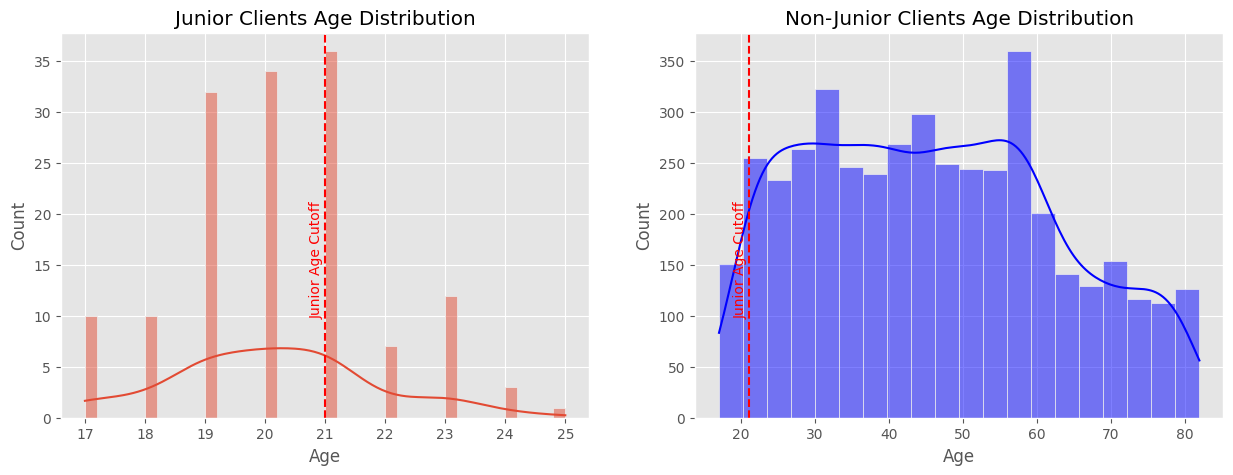

In [17]:
JUNIOR_AGE_CUTOFF = 21

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(junior_clients['client_age'], bins=40, ax=ax[0], kde=True)
ax[0].axvline(JUNIOR_AGE_CUTOFF, color='r', linestyle='--')
ax[0].text(JUNIOR_AGE_CUTOFF - .25, 10, 'Junior Age Cutoff', rotation=90, color='r')
ax[0].set_title('Junior Clients Age Distribution')
ax[0].set_xlabel('Age')

sns.histplot(client_df['client_age'], bins=20, ax=ax[1], color='b', kde=True)
ax[1].axvline(JUNIOR_AGE_CUTOFF, color='r', linestyle='--')
ax[1].text(JUNIOR_AGE_CUTOFF - 2, 100, 'Junior Age Cutoff', rotation=90, color='r')
ax[1].set_title('Non-Junior Clients Age Distribution')
ax[1].set_xlabel('Age')

plt.show()

For the cutoff the age 21 was chosen (meaning non-card-holders that are younger than the threshold or exactly at the threshold) since we can see a rapid decrease in Junior Card Holders after the proposed age. These remaining customers above the cutoff age that still own a Junior card could just remain there due to the reason that the bank may need some time to reissue regular cards; Which is why no clear cutoff age can be found in the distribution.

In [18]:
underage_clients = client_df[(client_df['client_age'] <= JUNIOR_AGE_CUTOFF) & (~client_df['has_card'])]

client_df = client_df[~client_df['client_id'].isin(underage_clients['client_id'])]
transaction = transaction[~transaction['account_id'].isin(underage_clients['account_id'])]

print(f'Number of underage clients: {underage_clients.shape[0]}')
print(f'Number of clients remaining after underage client removal: {client_df.shape[0]}')

Number of underage clients: 222
Number of clients remaining after underage client removal: 4133


## <a id='toc1_3_'></a>[Model Construction](#toc0_)

In the model construction step the main goal is to build a "counter quantity". The PKDD'99 dataset unfortunately only labelled preexisiting customers with an issue date. Customers who decided against a card may not be in the dataset or are at least not marked in such a way.

### <a id='toc1_3_1_'></a>[Processing Transactional Data](#toc0_)

The first task is to look if every account in the transactions dataframe has a "first transaction". This would make the calculation of the monthly balance much easier since everything can be summed up without having to worry that there were months without records in the transaction dataframe.

In [19]:
min_dates = transaction.groupby('account_id')['date'].min().reset_index()
min_dates.rename(columns={'date': 'min_date'}, inplace=True)

transactions_with_min_date = pd.merge(transaction, min_dates, on='account_id')

first_day_transactions = transactions_with_min_date[transactions_with_min_date['date'] == transactions_with_min_date['min_date']]
first_day_transactions = first_day_transactions.copy()

first_day_transactions['amount_equals_balance'] = first_day_transactions['amount'] == first_day_transactions['balance']

accounts_meeting_condition = first_day_transactions.groupby('account_id')['amount_equals_balance'].any().reset_index()

all_accounts_covered = accounts_meeting_condition['amount_equals_balance'].all()

print("Does every account's first day of transactions include at least one transaction where amount equals balance?", all_accounts_covered)

Does every account's first day of transactions include at least one transaction where amount equals balance? True


Since the goal is to have a roll-up window per month, the transactions need to get modified so that they aggregate their values on a per-month level.

The code first groups the transactions by `account_id` and `month`, and aggregates the data to calculate monthly `volume`, `credit`, `withdrawal`, and the number of transactions (`n_transactions`). After that the minimum and maximum month for each `account_id` gets calculated.

Finally, the cumulative sum of the volume column for each `account_id` is calculated, resulting in a running balance over time.

In [20]:
transaction['month'] = transaction['date'].dt.to_period('M')

transactions_monthly = transaction.groupby(['account_id', 'month']).agg(
    volume=('amount', 'sum'),
    credit=('amount', lambda x: x[transaction.loc[x.index, 'type'] == 'CREDIT'].sum()),
    withdrawal=('amount', lambda x: x[transaction.loc[x.index, 'type'] == 'WITHDRAWAL'].sum()),
    n_transactions=('amount', 'size')
).reset_index()

transactions_monthly['month'] = pd.PeriodIndex(transactions_monthly['month'])

date_ranges = transactions_monthly.groupby('account_id')['month'].agg(['min', 'max'])

def reindex_df(group, account_id):
    idx = pd.period_range(start=group['month'].min(), end=group['month'].max(), freq='M')
    group.set_index('month', inplace=True)
    group = group.reindex(idx, fill_value=0)
    group.reset_index(inplace=True)
    group.rename(columns={'index': 'month'}, inplace=True)
    group['account_id'] = account_id
    return group

transactions_monthly = (transactions_monthly.groupby('account_id')
                        .apply(lambda x: reindex_df(x, x.name))
                        .reset_index(level=0, drop=True))

transactions_monthly['balance'] = transactions_monthly.groupby('account_id')['volume'].cumsum()

transactions_monthly.sample(5)

month  account_id   volume   credit  withdrawal  n_transactions  \
5   1998-01        2644  17485.7   5064.1     12421.6              13   
22  1995-05        1297  42004.4  20720.8     21283.6               7   
15  1998-08         250  11099.8   6699.2      4400.6               6   
23  1998-08        1258   5210.7   2963.1      2247.6               6   
36  1996-05        3316  33962.0  15492.4     18469.6               5   

      balance  
5     46045.3  
22   933208.2  
15   202891.1  
23   127985.3  
36  1210751.5

And now as the sample output shows, we have an aggregation for all months and accounts with a summary on the monthly credit, withdrawal, balance and n_transactions.

### <a id='toc1_3_2_'></a>[Defining Roll-Up Windows of Transactions](#toc0_)

Before we can continue to construct the roll-up windows for all customers, we need to propose a hypothetical `card_issued` date for the clients that have **no card** (negative samples).

To not introduce a new bias towards card-holders or non-card-holders the idea here is to sample issue dates from the card holders. An important point is to eliminate or surpress seasonality as good as possible (hence a 13 month roll-up window will be constructed). Such seasonality could also emerge if we just sample random dates - To not encounter that issue and get a counter set to our existing card holders, the distribution of days between account creation and the issue date is used. This way we can ensure that we don't sample dates that lie outside of a non-card customer's account activity.

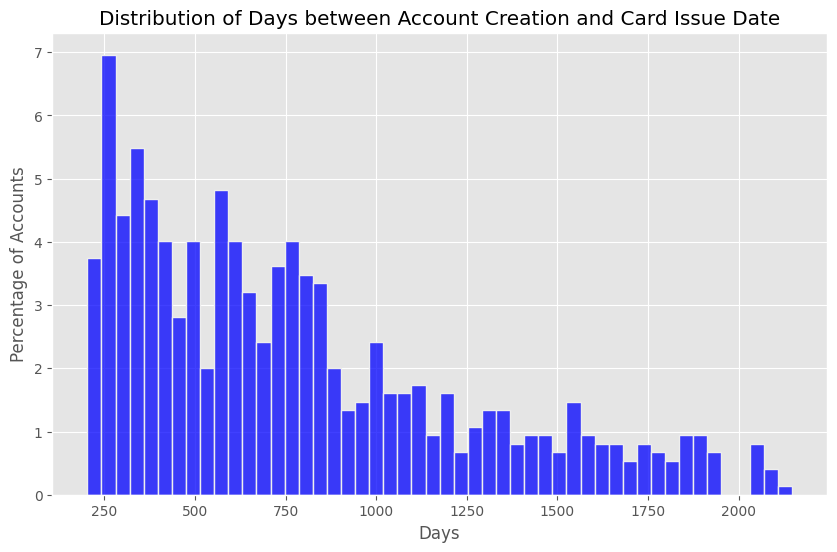

In [21]:
clients_with_cards = client_df[~client_df['card_issued'].isnull()]
time_between_creation_and_issue = (clients_with_cards['card_issued'] - clients_with_cards['account_date']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='blue', linewidth=1)

plt.title('Distribution of Days between Account Creation and Card Issue Date')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.grid(True)

plt.show()

When looking at the distribution of how many days it usually takes an account to get a card is that usually cards get issued the earliest 200 days after account creation. The issuances decrease steadily but in rare cases it can even take a customer over 5 years (>2000 days) to decide to get a credit card.

Based on this distribution we now will sample the deltas (time between account creation and issuance) for our non-card holders.

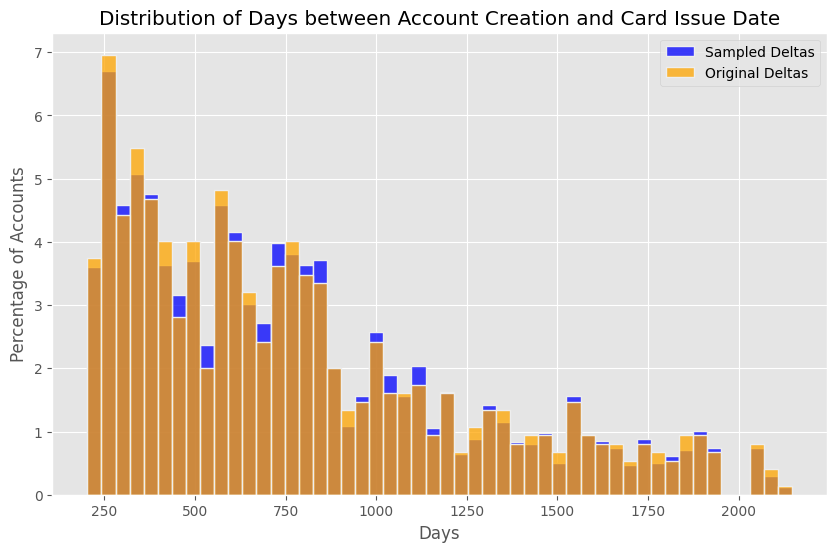

In [22]:
np.random.seed(1337)

sampled_deltas = np.random.choice(time_between_creation_and_issue, size=len(client_df[client_df['card_issued'].isnull()]))

plt.figure(figsize=(10, 6))
sns.histplot(sampled_deltas, bins=50, stat='percent', kde=False, color='blue', linewidth=1, label='Sampled Deltas')
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='orange', linewidth=1, label='Original Deltas')

plt.title('Distribution of Days between Account Creation and Card Issue Date')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.legend()
plt.grid(True)

plt.show()

Through the random sampling we now can use every negative sample from the dataset. Additionally, through random sampling we added a small amount of noise which is expected to have a generalizing effect on the data.

To check if we now have an issue date for all customers the following check is executed:

In [23]:
if len(client_df[client_df['card_issued'].isnull()]) > 0:
    client_df.loc[client_df['card_issued'].isnull(), 'card_issued'] = client_df.loc[client_df['card_issued'].isnull(), 'account_date'] + pd.to_timedelta(sampled_deltas, unit='D')
    
print(f'Number of NaT/NaN values in card_issued: {client_df["card_issued"].isnull().sum()}')

Number of NaT/NaN values in card_issued: 0


The check shows that we now successfully sampled an issue date for all customers.

In [24]:
card_issued = card.groupby('disp_id')['card_issued'].min().reset_index()
card_issued.head(5)

disp_id card_issued
0        9  1998-10-16
1       19  1998-03-13
2       41  1995-09-03
3       42  1998-11-26
4       51  1995-04-24

We now can merge together the issued dates to the monthly transaction aggregation.

In [25]:
transactions_monthly = transactions_monthly.merge(client_df[['account_id', 'card_issued']], left_on='account_id', right_on='account_id', how='left')

transactions_monthly.head()

month  account_id   volume   credit  withdrawal  n_transactions  balance  \
0  1995-03           1   1000.0   1000.0         0.0               1   1000.0   
1  1995-04           1  16298.2  16298.2         0.0               3  17298.2   
2  1995-05           1   5858.0   5858.0         0.0               3  23156.2   
3  1995-06           1   3979.6   3779.6       200.0               3  27135.8   
4  1995-07           1   9087.9   3787.9      5300.0               3  36223.7   

  card_issued  
0  1998-09-18  
1  1998-09-18  
2  1998-09-18  
3  1998-09-18  
4  1998-09-18

Now, let's see if the join worked correctly and we don't have any transactions without a `card_issued` date anymore.

In [26]:
assert transactions_monthly['card_issued'].isnull().sum() == 0

### <a id='toc1_3_3_'></a>[Validating Negative Examples](#toc0_)
The goal for our model will be to be able to learn from a base set of customers (with and without cards) that lived through the same economic circumstances. To validate that all customers in our current set are represented in a well distributed way, this next plot looks at the distribution of volume throughout the datasets timeframe.

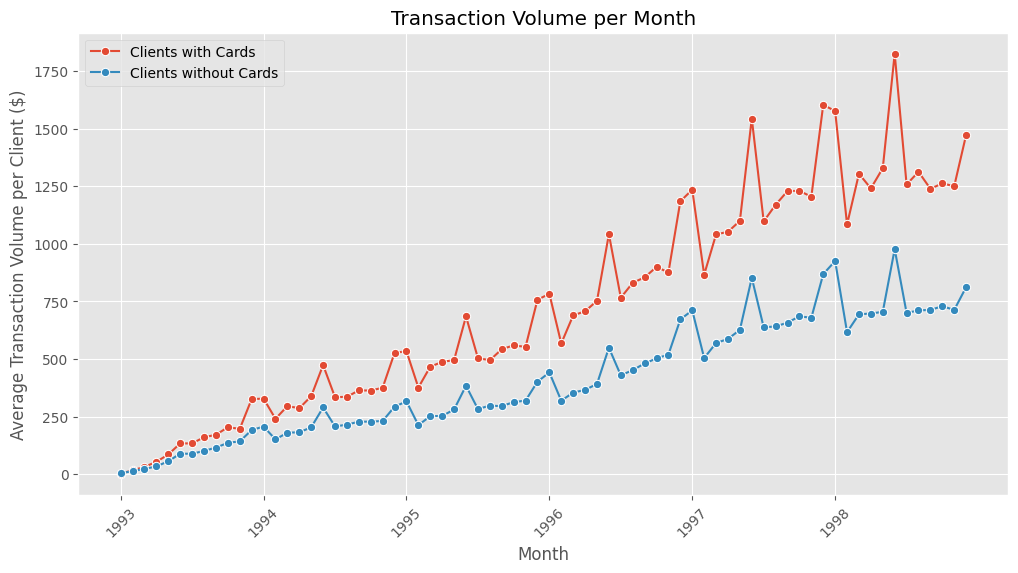

In [27]:
transactions_monthly['has_card'] = transactions_monthly['account_id'].isin(client_df[client_df['has_card']]['account_id'])

transactions_monthly.reset_index(inplace=True)
transactions_monthly['id'] = range(len(transactions_monthly))
transactions_monthly.set_index('id', inplace=True)

transactions_with_cards = transactions_monthly[transactions_monthly['has_card'] == True]
transactions_without_cards = transactions_monthly[transactions_monthly['has_card'] == False]

grouped_with_cards = transactions_with_cards.groupby('month')['volume'].sum().reset_index()
grouped_without_cards = transactions_without_cards.groupby('month')['volume'].sum().reset_index()

grouped_with_cards['month'] = grouped_with_cards['month'].astype(str)
grouped_without_cards['month'] = grouped_without_cards['month'].astype(str)

grouped_with_cards['avg_volume_per_client'] = grouped_with_cards['volume'] / transactions_with_cards.shape[0]
grouped_without_cards['avg_volume_per_client'] = grouped_without_cards['volume'] / transactions_without_cards.shape[0]

plt.figure(figsize=(12, 6))

sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_with_cards, marker='o', label='Clients with Cards')
sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_without_cards, marker='o', label='Clients without Cards')

plt.title('Transaction Volume per Month')
plt.xlabel('Month')
plt.ylabel('Average Transaction Volume per Client ($)')
plt.legend()
plt.grid(True)

plt.xticks(ticks=grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')], rotation=45)
plt.gca().set_xticklabels([label[:4] for label in grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')]])

plt.show()


We can see that we generally have less transaction volume for clients without cards, though the trends stay the same for both customer types: Around Christmas and New Year's Eve the transaction volume rises rapidly. The same observation can be seen in the middle of each year, perhaps where customers go on summer vacation.

In order to construct the Roll-Up Window for every customer, the difference of each month to the issue date's month needs to get calculated. After calculating the difference at each month the size of the Roll-Up window can be determined. In this case a window of 13 months was chosen, so a year plus a lag month which aims to capture the client's decision time or the banks time until the card has been sent out to the customer.

In [28]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])
transactions_monthly['card_issued_period'] = transactions_monthly['card_issued'].dt.to_period('M')

transactions_monthly['month_diff'] = transactions_monthly.apply(lambda row: (row['card_issued_period'] - row['month']).n if pd.notnull(row['card_issued_period']) and pd.notnull(row['month']) else None, axis=1)

filtered_transactions = transactions_monthly[transactions_monthly['month_diff'].between(1, 13)]

transactions_monthly.sample(5)

index    month  account_id   volume   credit  withdrawal  \
id                                                                  
44634    44634  1998-05        1252  47796.5  24851.8     22944.7   
44011    44011  1997-07        1235  10518.0   4411.4      6106.6   
95818    95818  1997-12        2651  98919.1  54142.5     44776.6   
73459    73459  1996-08        2035  52500.5  29600.5     22900.0   
162431  162431  1995-08        8998   1900.0   1900.0         0.0   

        n_transactions    balance card_issued  has_card card_issued_period  \
id                                                                           
44634                5  1777803.9  1999-05-20     False            1999-05   
44011                6   373341.3  1995-12-18     False            1995-12   
95818                6  4442381.9  1995-07-09      True            1995-07   
73459                3   155070.1  2000-06-14     False            2000-06   
162431               1    21400.0  1997-11-23     False            1997-11   

        month_diff  
id                  
44634           12  
44011          -19  
95818          -29  
73459           46  
162431          27

The sample and assertions shows, as expected, the dataframe now has a `month_diff` column describing how many months until the issue month.

#### <a id='toc1_3_3_1_'></a>[Pivoting the transactions](#toc0_)

An issue at this point can be that an account may have months without any transactions, so there needs to be a more thorough process to interpolate the data:
- **Volume, Withdrawal, Credit and Number of Transactions**: If there are missing months in these variables we can just set `0` as their value as there has not been any activity if there were no recorded months.
- **Balance**: The balance will get recursively set to the last preceding recorded month. So if there are consecutive "missing" months in transactions the balance will always be set to the last recorded month.

In [29]:
account_summary = pd.DataFrame(filtered_transactions['account_id'].unique(), columns=['account_id'])

variables_to_pivot = ['volume', 'withdrawal', 'credit', 'n_transactions', 'balance']

for variable in variables_to_pivot:
    grouped = filtered_transactions.groupby(['account_id', 'month_diff'])[variable].sum().reset_index()
    pivot = grouped.pivot(index='account_id', columns='month_diff', values=variable).reset_index()
    pivot.columns = ['account_id'] + [f'{variable}_month_diff_{int(col)}' if col != 'account_id' else 'account_id' for col in pivot.columns[1:]]
    account_summary = pd.merge(account_summary, pivot, on='account_id', how='left')

for variable in ['volume', 'withdrawal', 'credit', 'n_transactions']:
    account_summary.update(account_summary.filter(regex=f'^{variable}_').fillna(0))

def find_last_balance(account_id, starting_month_diff):
    higher_month_diff = transactions_monthly[
        (transactions_monthly['account_id'] == account_id) & 
        (transactions_monthly['month_diff'] >= starting_month_diff)
    ].sort_values('month_diff')
    
    last_balance_row = higher_month_diff[higher_month_diff['balance'].notna()].head(1)
    
    if not last_balance_row.empty:
        return last_balance_row.iloc[0]['balance']
    else:
        return 0

balance_columns = [col for col in account_summary.columns if 'balance_month_diff_' in col]
for idx, row in account_summary.iterrows():
    for col in balance_columns:
        if pd.isna(row[col]):
            month_diff = int(col.split('_')[-1])
            last_balance = find_last_balance(row['account_id'], month_diff + 1)
            account_summary.at[idx, col] = last_balance
            
account_summary.sample(5)

account_id  volume_month_diff_1  volume_month_diff_2  \
381          498              39659.4              34483.7   
1952        2492              13527.2              15698.0   
310          408              32231.8              31975.1   
1805        2312                  0.0                  0.0   
2326        2958               9079.5              20019.4   

      volume_month_diff_3  volume_month_diff_4  volume_month_diff_5  \
381               29442.9              42462.9              65889.1   
1952              14574.7              16752.0              15593.3   
310               28891.9              20395.0              30101.3   
1805                  0.0                  0.0                  0.0   
2326               8629.8              13028.9              14947.1   

      volume_month_diff_6  volume_month_diff_7  volume_month_diff_8  \
381               36413.9              37090.9              40801.7   
1952              16138.8              12432.8               9681.2   
310               28733.4              25560.1              22529.5   
1805                  0.0                  0.0                  0.0   
2326               5283.6               5265.0               5265.0   

      volume_month_diff_9  volume_month_diff_10  volume_month_diff_11  \
381               34286.6               61109.7               57040.4   
1952               9434.3                6932.7                7620.0   
310               19207.1               43833.1               38023.2   
1805              14220.2               12930.7                8808.9   
2326               5265.0                5265.0                 400.0   

      volume_month_diff_12  volume_month_diff_13  withdrawal_month_diff_1  \
381                41033.8               41389.2                  18474.6   
1952                   0.0                   0.0                   6555.6   
310                24737.1               25429.5                  18736.6   
1805                8800.5               12903.9                      0.0   
2326                   0.0                   0.0                   3755.6   

      withdrawal_month_diff_2  withdrawal_month_diff_3  \
381                   13314.6                   8314.6   
1952                   8715.6                   7595.6   
310                   18456.6                  15356.6   
1805                      0.0                      0.0   
2326                  14675.6                   3275.6   

      withdrawal_month_diff_4  withdrawal_month_diff_5  \
381                   21354.6                  34334.6   
1952                   9755.6                   8595.6   
310                    6856.6                   9936.6   
1805                      0.0                      0.0   
2326                   7675.6                   9575.6   

      withdrawal_month_diff_6  withdrawal_month_diff_7  \
381                   15314.6                  16014.6   
1952                   9135.6                   5420.6   
310                   15236.6                  12056.6   
1805                      0.0                      0.0   
2326                     14.6                      0.0   

      withdrawal_month_diff_8  withdrawal_month_diff_9  \
381                   19734.6                  13214.6   
1952                   2700.0                   2500.0   
310                    9056.6                   5056.6   
1805                      0.0                   8832.0   
2326                      0.0                      0.0   

      withdrawal_month_diff_10  withdrawal_month_diff_11  \
381                    40034.6                   25494.6   
1952                       0.0                       0.0   
310                    30376.6                   17876.6   
1805                    7526.6                    3406.6   
2326                       0.0                       0.0   

      withdrawal_month_diff_12  withdrawal_month_diff_13  credit_month_diff_1  \
381                    19954.6         

As we can see, the columns get pivoted correctly and now every account has its 13-month roll-up window so we can merge together the window with the existing client dataframe (main dataframe).

In [30]:
client_df = client_df.merge(account_summary, on='account_id', how='inner')

### <a id='toc1_3_4_'></a>[Bringing the data together](#toc0_)

Since we now are done with the main model construction, the following visualization aims to show and recap the process we went through with the data at hand.

In [31]:
n_lt_13_month_hist = transactions_monthly['account_id'].nunique()-filtered_transactions['account_id'].nunique()

preprocessing_summary = [
        n_merged_base_client,
        -len(junior_clients),
        -n_lt_13_month_hist,
        -len(underage_clients),
        len(client_df)
]

fig = go.Figure(go.Waterfall(
        name = "20", orientation = "v",
        measure = ["absolute", "relative", "relative", "relative", "total"],
        x = ["Base Client List", 
             "Junior Clients", 
             "Clients with less than 13 Months of Transaction History", 
             "Non-Card-Holders that are underage", 
             "Remaining Clients"],
        textposition = "outside",
        y = preprocessing_summary,
        text = [str(x) for x in preprocessing_summary],
        connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Profit and loss statement 2018",
        showlegend = True
)

fig.show()

The baseline dataset consists of 4500 clients. Of these 4500 clients 145 are Junior Clients and those need to get removed since the task at hand does not focus on this customer group. After the Junior card removal clients with less than 13 months of history were discarded since those do not have enough time as a customer to build a roll-up window and therefore would not be suitable to make any predictions with. An implicit dependency with the Junior cards is the age - Customers without cards that may fall into the category of Junior customers also got discarded since our model would not be suitable to classify if such "underage" customers should get a card or not. **The remaining dataset or "golden record" therefore consists of 3715 customers.**

## <a id='toc1_4_'></a>[Exploratory Data Analysis](#toc0_)

In this section we will explore the structure of the data at hand.

### <a id='toc1_4_1_'></a>[Exploring Missing Values](#toc0_)

The first step is to look at missing values, respecitvely finding out if there are completely empty columns.

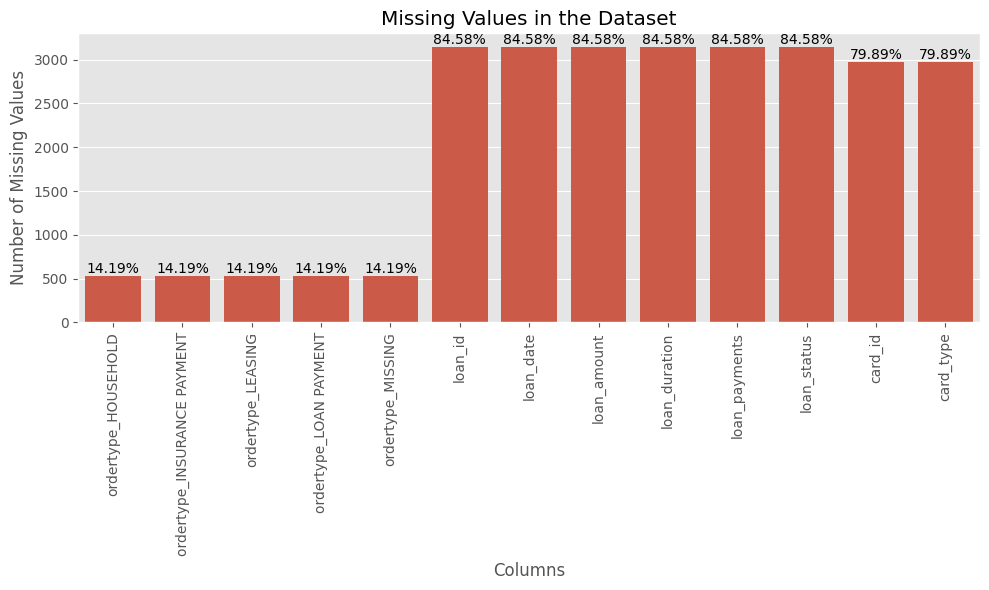

In [32]:
missing_values = client_df.isnull().sum()

missing_values = pd.DataFrame({
    'Number of Missing Values': missing_values[missing_values > 0],
    'Percentage of Missing Values': [
        f"{x:.2f}%" for x in (missing_values[missing_values > 0] / client_df.shape[0] * 100).round(2)
    ]
}, columns=['Number of Missing Values', 'Percentage of Missing Values'])

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values['Number of Missing Values'])

for index, value in enumerate(missing_values['Number of Missing Values']):
    plt.text(index, value, missing_values['Percentage of Missing Values'][index], ha='center', va='bottom')

plt.title('Missing Values in the Dataset')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The visualization does not show any abnormality. Some ordertypes seem to be entirely empty since there are accounts that don't have any orders. Additionally there the same percentages across all loan-specific columns since most accounts haven't taken out loans. And at last, we can see how there are numerous customers without a card, which is also an expected observation.

### <a id='toc1_4_2_'></a>[Cardholders vs Non-Cardholders](#toc0_)

In this next step the goal is to get an overview on how the customers are distributed when it comes to owning a card or not.

In [33]:
card_owners = client_df[client_df['has_card']]
non_card_owners = client_df[~client_df['has_card']]

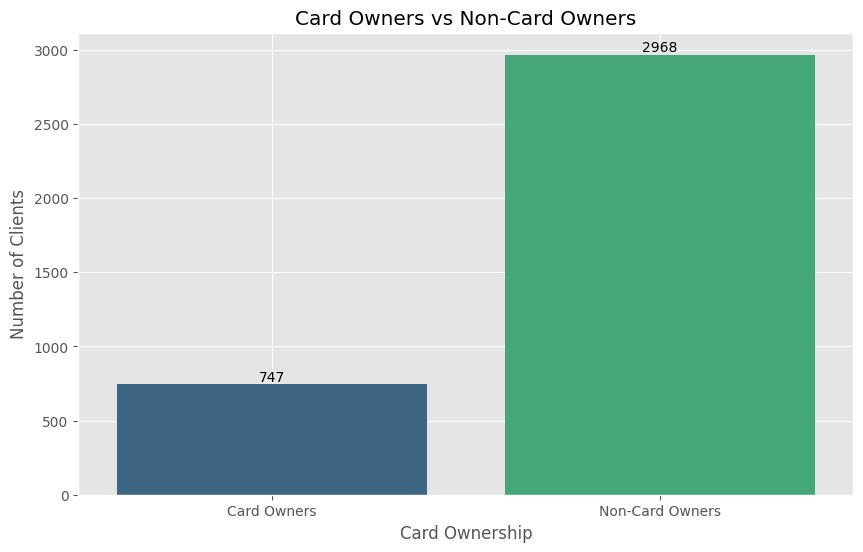

In [34]:
data = {
    'Card Ownership': ['Card Owners', 'Non-Card Owners'],
    'Number of Clients': [card_owners.shape[0], non_card_owners.shape[0]]
}

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Ownership', y='Number of Clients', data=data, palette='viridis', hue='Card Ownership')

for index, value in enumerate(data['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Owners vs Non-Card Owners')
plt.xlabel('Card Ownership')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()


The "golden record" has `747` card holders and `2968` customers without cards. The non-card owners therefore clearly overweigh.

### <a id='toc1_4_3_'></a>[ Card Types](#toc0_)

The taks doesn't require to classify gold vs. classic card holders separately, though it might be beneficial to also look at how the card owners are distributed in their "card class".

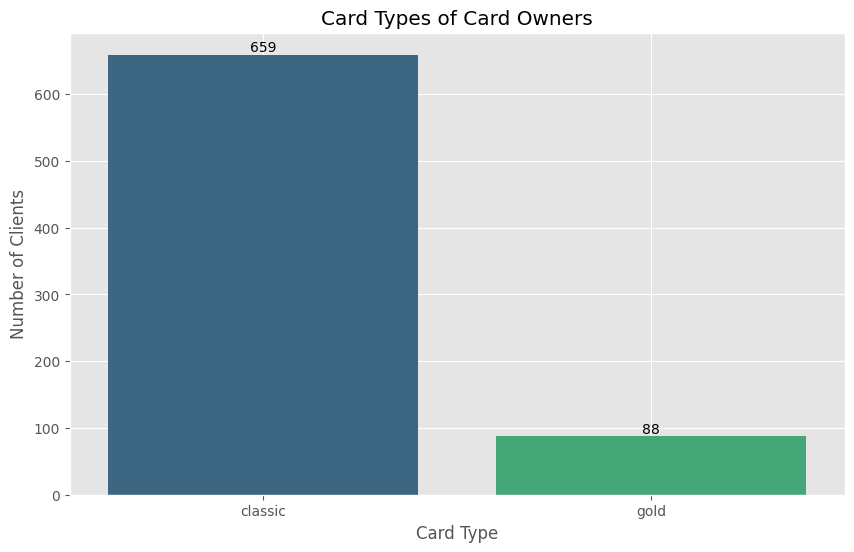

In [35]:
card_types = card_owners['card_type'].value_counts()
card_types = card_types.reset_index()
card_types.columns = ['Card Type', 'Number of Clients']

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Type', y='Number of Clients', data=card_types, palette='viridis', hue='Card Type')

for index, value in enumerate(card_types['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Types of Card Owners')
plt.xlabel('Card Type')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()

The card type distribution shows that the majority of cardholders owns classic cards. Gold cards seem to only be sold rarely.

### <a id='toc1_4_4_'></a>[Distribution of Issuance Dates](#toc0_)

This following plot should show the distribution of card issuance dates for both Card Owners and customers without cards.

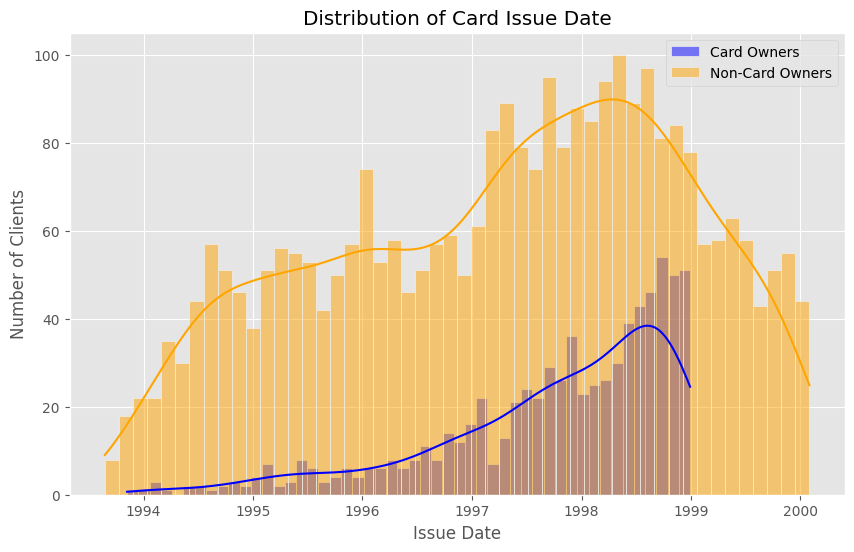

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(card_owners['card_issued'], bins=50, kde=True, color='blue', label='Card Owners')
sns.histplot(non_card_owners['card_issued'], bins=50, kde=True, color='orange', label='Non-Card Owners')

plt.title('Distribution of Card Issue Date')
plt.xlabel('Issue Date')
plt.ylabel('Number of Clients')
plt.legend()
plt.grid(True)

plt.show()

Both distributions have their peak issue dates around 1997-1998. This indicates that during this period, there was a high activity of credit card issuance. It might be due to a marketing campaign, economic conditions, or other factors.

The similarity in trends between card owners and non-card owners shows that the sampling method used to fill the missing issue dates for non-card owners was appropriate and maintained the overall temporal distribution trend of the original data.

### <a id='toc1_4_5_'></a>[Balance and Volume over time](#toc0_)

To get a glimpse on how temporal client traits might be used in modelling later on we take a look at two account samples (Account Number 14 and 18):

In [37]:
client_df[client_df['account_id'].isin([14, 18])]

disp_id  client_id  account_id  account_district_id account_frequency  \
8        19         19          14                   47   MONTHLY CHARGES   
11       24         24          18                   43    WEEKLY CHARGES   

   account_date  client_district_id client_gender client_birth_date  \
8    1996-11-27                  47          MALE        1942-12-28   
11   1993-05-26                  43        FEMALE        1939-07-29   

    client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
8           57                  1.0                          0.0   
11          60                  NaN                          NaN   

    ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
8                 0.0                     0.0                0.0      NaN   
11                NaN                     NaN                NaN      NaN   

   loan_date  loan_amount  loan_duration  loan_payments loan_status  card_id  \
8        NaT          NaN            NaN            NaN         NaN      2.0   
11       NaT          NaN            NaN            NaN         NaN      NaN   

   card_type card_issued  district_id_x client_district_district_name  \
8    classic  1998-03-13             47                     Pardubice   
11       NaN  1994-04-05             43                Hradec Kralove   

   client_district_region  client_district_population  \
8            east Bohemia                      162580   
11           east Bohemia                      161854   

    client_district_n_municipalities_with_inhabitants_lt_499  \
8                                                  83          
11                                                 73          

    client_district_n_municipalities_with_inhabitants_500_to_1999  \
8                                                  26               
11                                                 21               

    client_district_n_municipalities_with_inhabitants_2000_to_9999  \
8                                                   5                
11                                                  6                

    client_district_n_municipalities_with_inhabitants_gt_10000  \
8                                                   1            
11                                                  1            

    client_district_n_cities  client_district_ratio_urban_inhabitants  \
8                          6                                     72.8   
11                         6                                     76.3   

    client_district_average_salary client_district_unemployment_rate_95  \
8                             9538                                 1.51   
11                            9425                                 1.72   

    client_district_unemployment_rate_96  \
8                                   1.81   
11                                  2.50   

    client_district_enterpreneurs_per_1000_inhabitants  \
8                                                 111    
11                                                125    

   client_district_n_commited_crimes_95  client_district_n_commited_crimes_96  \
8                                  6079                                  5410   
11                                 4085                                  3891   

    district_id_y account_district_district_name account_district_region  \
8              47                      Pardubice            east Bohemia   
11             43                 Hradec Kralove            east Bohemia   

    account_district_population  \
8                        162580   
11                       161854   

    account_district_n_municipalities_with_inhabitants_lt_499  \
8                                                  83           
11                                                 73           

    account_district_n_municipalities_with_inhabitants_500_to_1999  \
8                                                  26                
11      

Account 14 has a card while account 18 does not, however both accounts otherwise are fairly similar; No loans were taken out, both clients originate from the same region, and are roughly in the same age bracket.

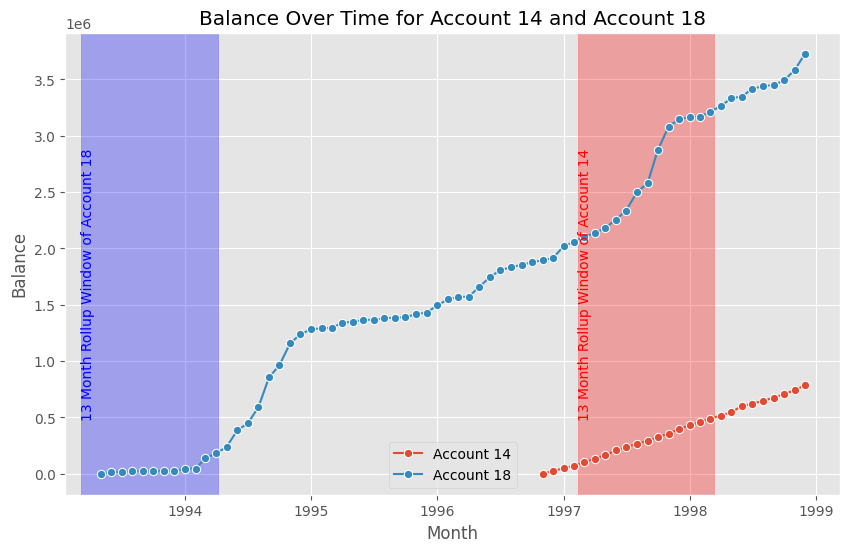

In [38]:
account_14 = transactions_monthly[transactions_monthly['account_id'] == 14].copy()
account_14['month'] = account_14['month'].dt.to_timestamp()

account_18 = transactions_monthly[transactions_monthly['account_id'] == 18].copy()
account_18['month'] = account_18['month'].dt.to_timestamp()

plt.figure(figsize=(10, 6))
sns.lineplot(data=account_14, x='month', y='balance', marker='o', label='Account 14')
sns.lineplot(data=account_18, x='month', y='balance', marker='o', label='Account 18')

plt.axvspan(account_14['card_issued'].min() - pd.DateOffset(months=13), account_14['card_issued'].min(), color='r', alpha=0.3)
plt.axvspan(account_18['card_issued'].min() - pd.DateOffset(months=13), account_18['card_issued'].min(), color='b', alpha=0.3)

plt.text(account_14['card_issued'].min() - pd.DateOffset(months=13), 500000, '13 Month Rollup Window of Account 14', rotation=90, color='r')
plt.text(account_18['card_issued'].min() - pd.DateOffset(months=13), 500000, '13 Month Rollup Window of Account 18', rotation=90, color='b')

plt.title('Balance Over Time for Account 14 and Account 18')
plt.xlabel('Month')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)

plt.show()

The balance over time show quite distinctive patterns:
- Account 14:
  - The balance for Account 14 (represented by the red line) starts at zero and shows a steady, linear increase over time from around 1997 to 1999.
- Account 18:
  - The balance for Account 18 shows a rather stable account balance up until the last third before issuance where a more rapid increase can be observed.

Nonetheless it can be said that both accounts follow the trend of the overall observed timespan of increasing activity over time. Both balances grew over time, so both customers seem to save up over time.

Next, the volume might also show some more behavioral patterns, therefore it gets explored the same way:

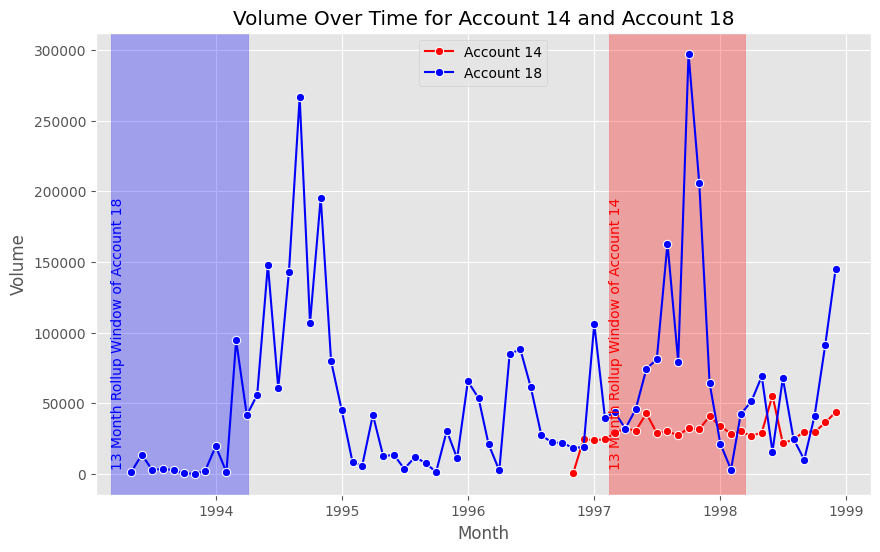

In [39]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='volume', data=account_14, marker='o', label='Account 14', color='r')
sns.lineplot(x='month', y='volume', data=account_18, marker='o', label='Account 18', color='b')

plt.axvspan(account_14['card_issued'].min() - pd.DateOffset(months=13), account_14['card_issued'].min(), color='r', alpha=0.3)
plt.axvspan(account_18['card_issued'].min() - pd.DateOffset(months=13), account_18['card_issued'].min(), color='b', alpha=0.3)

plt.text(account_14['card_issued'].min() - pd.DateOffset(months=13), 5000, '13 Month Rollup Window of Account 14', rotation=90, color='r')
plt.text(account_18['card_issued'].min() - pd.DateOffset(months=13), 5000, '13 Month Rollup Window of Account 18', rotation=90, color='b')

plt.title('Volume Over Time for Account 14 and Account 18')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)

- Account 18 experienced high volume activity between the years of 1994 and 1995 and another high peak between 1997 and 1998.
- Account 14 in comparison shows a rather stable volume activity and does not peak as high as the account without a card.

When looking at both Rollup windows, we can clearly see a difference: Account 18 had a rapid increase in volume activity right before the sampled issuance date while Account 14 stayed rather stable throughout the rollup window.

### <a id='toc1_4_6_'></a>[Volume before card purchase](#toc0_)

To now look closer at the months before an issue date, the following visualization shows the distribution of data for each month in the rollup window for card holders and customers without cards:

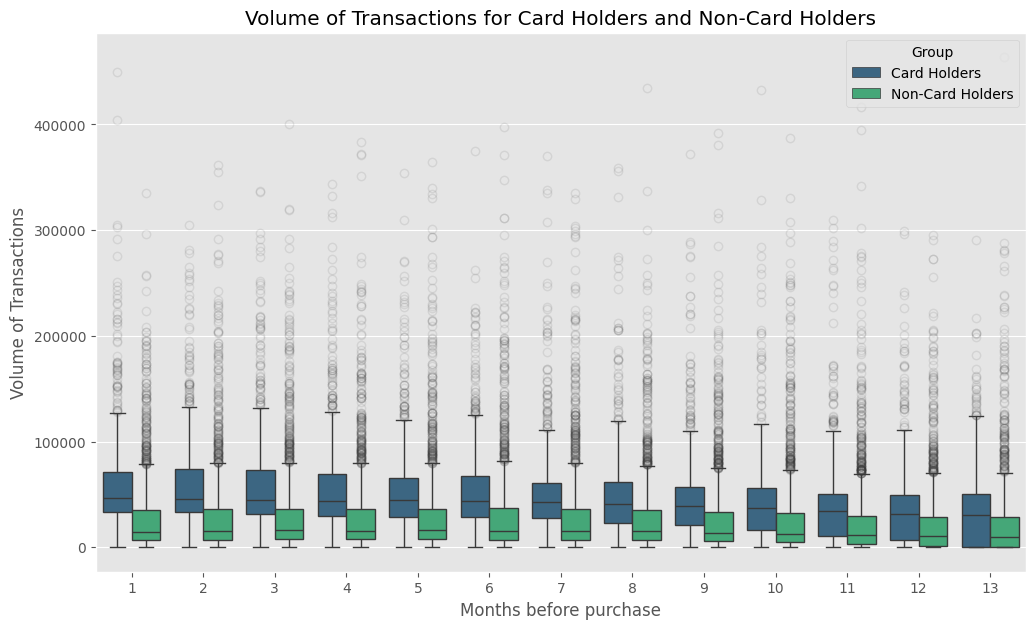

In [40]:
volume_month_diff_columns = [col for col in account_summary.columns if 'volume_month_diff_' in col]

combined_data_all = []

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in card_owners[col]:
        combined_data_all.append({'Month': month_num, 'Volume': value, 'Group': 'Card Holders'})

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in non_card_owners[col]:
        combined_data_all.append({'Month': month_num, 'Volume': value, 'Group': 'Non-Card Holders'})

combined_df_all = pd.DataFrame(combined_data_all)

plt.figure(figsize=(12, 7))
sns.boxplot(x='Month', y='Volume', hue='Group', data=combined_df_all, palette='viridis', flierprops=dict(alpha=0.1))
plt.title('Volume of Transactions for Card Holders and Non-Card Holders')
plt.xlabel('Months before purchase')
plt.ylabel('Volume of Transactions')
plt.legend(title='Group')

plt.show()

Overall the cardholders show a stronger decrease during the 13-month rollup window. We can also observe that the cardholders are skewed towards a higher volume of transactions than customers without cards.

To conclude, the rollup window definitely shows a distinguishable pattern between card holders and clients without cards.

### <a id='toc1_4_7_'></a>[Age distribution](#toc0_)

In an effort to eliminate potential Junior Card customers we have already look at the age distribution. Nonetheless, this exploration now aims to look at potential differences between cardholders and clients without cards in order to mkae out if the age is a viable feature for prediction later on.

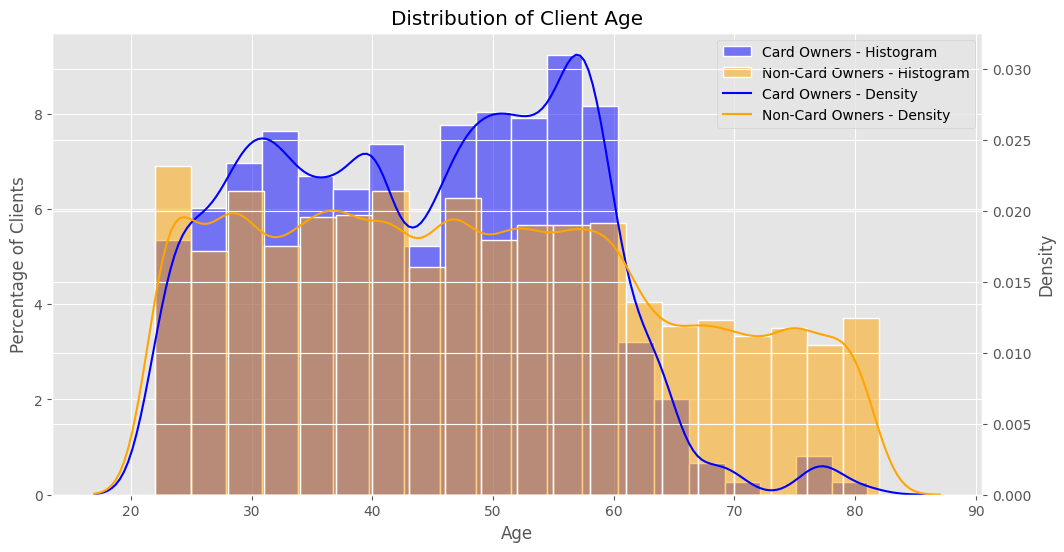

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.histplot(card_owners['client_age'], bins=20, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners - Histogram', alpha=0.5, ax=ax1, zorder=2)
sns.histplot(non_card_owners['client_age'], bins=20, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners - Histogram', alpha=0.5, ax=ax1, zorder=2)

ax2 = ax1.twinx()

sns.kdeplot(card_owners['client_age'], bw_adjust=0.5, color='blue', label='Card Owners - Density', ax=ax2, zorder=2)
sns.kdeplot(non_card_owners['client_age'], bw_adjust=0.5, color='orange', label='Non-Card Owners - Density', ax=ax2, zorder=2)

ax1.set_title('Distribution of Client Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percentage of Clients')
ax2.set_ylabel('Density')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.grid(True, zorder=-1)
plt.show()

The distribution shows a vast difference between card holders and non-card clients in the ages between ~65 and 90. Only a small fraction of customers in that age range own cards.

## <a id='toc1_5_'></a>[Feature Engineering](#toc0_)

In the Feature Engineering section the objective is to derive new features from ones we have in hopes of finding new predictive features that may contribute to a better performance of the models later on.

### <a id='toc1_5_1_'></a>[Demographic-Based Features](#toc0_)

#### <a id='toc1_5_1_1_'></a>[Defining Age Groups](#toc0_)
As already explored, the age of customers might be a reasonable predictor for card owners. Though not only the continuous representation of age may be of value for modelling but also an age bracket representation might capture the age as category in a more reasonable way: 

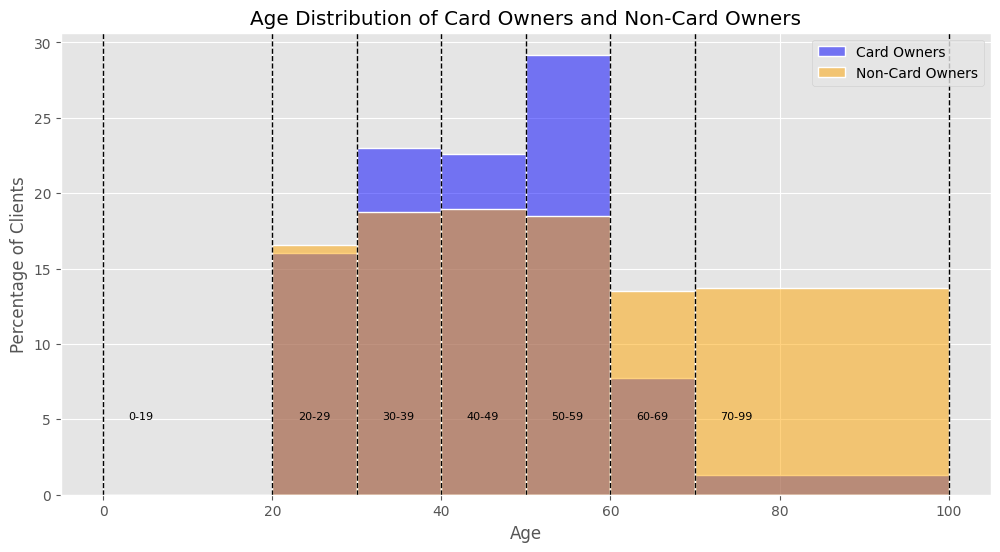

In [42]:
age_brackets = [0, 20, 30, 40, 50, 60, 70, 100]

plt.figure(figsize=(12, 6))
sns.histplot(card_owners['client_age'], bins=age_brackets, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners', alpha=0.5)
sns.histplot(non_card_owners['client_age'], bins=age_brackets, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners', alpha=0.5)

for age_bracket in age_brackets:
    plt.axvline(age_bracket, color='black', linestyle='--', linewidth=1)
    
plt.title('Age Distribution of Card Owners and Non-Card Owners')
plt.xlabel('Age')
plt.ylabel('Percentage of Clients')

for i in range(len(age_brackets) - 1):
    plt.text(age_brackets[i] + 3, 5, f'{age_brackets[i]}-{age_brackets[i+1]-1}', fontsize=8, color='black')
    
plt.legend()
plt.grid(True)

plt.show()

To put customers into age group, mostly 10-year bins were defined up until age 70 where just one age group remains to represent the age group with the least cards per customer.

In [43]:
client_df['age_bracket'] = pd.cut(client_df['client_age'], bins=age_brackets, right=False)

age_bracket_counts = client_df['age_bracket'].value_counts().reset_index()
age_bracket_counts.columns = ['Age Bracket', 'Number of Clients']

age_bracket_counts

Age Bracket  Number of Clients
0    [50, 60)                767
1    [40, 50)                732
2    [30, 40)                729
3    [20, 30)                611
4    [60, 70)                460
5   [70, 100)                416
6     [0, 20)                  0

#### <a id='toc1_5_1_2_'></a>[Age at loan](#toc0_)
Another demographic or age-related metric of use may be the age a customer had when they took out a loan.

In [44]:
client_df['client_age_at_loan'] = (pd.to_datetime(client_df['loan_date']) - pd.to_datetime(client_df['client_birth_date'])).dt.days // 365

client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

#### <a id='toc1_5_1_3_'></a>[Account age](#toc0_)

Another age specific feature that can be derived is the account age. To calculate the account age the key date 2000-01-01 was defined to use for account age calculation.

In [45]:
client_df['account_age'] = (pd.to_datetime('2000-01-01') - pd.to_datetime(client_df['account_date'])).dt.days // 365

client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

### <a id='toc1_5_2_'></a>[Financial Features](#toc0_)

#### <a id='toc1_5_2_1_'></a>[Average Monthly Payment Ratio](#toc0_)

A good marker of credit risk might be the ratio of monthly loan payment to average salary in the account's district. By comparing the client's loan payments to the average salary in their district, the bank can evaluate the affordability of the loan for the client. A high ratio indicates that the loan payments take up a significant portion of the average salary, which could suggest potential difficulties in loan or credit repayment.

In [46]:
client_df['monthly_payment_ratio'] = client_df['loan_payments'] / client_df['account_district_average_salary']

### <a id='toc1_5_3_'></a>[District Features](#toc0_)

#### <a id='toc1_5_3_1_'></a>[Client-Account Region Match](#toc0_)

Since accounts and clients can have two distinct regions which they are registered in it, the `region_match` feature will capture if both regions match and a client has direct access to the bank through the same respective region.

In [47]:
client_df['region_match'] = client_df['client_district_region'] == client_df['account_district_region']

#### <a id='toc1_5_3_2_'></a>[District Population Density](#toc0_)

Client District Population Density:
- Population density can be correlated with economic activity and employment opportunities. High-density areas might have more diverse job opportunities, potentially reducing credit risk.

Account District Population Density:
- Understanding the economic vibrancy of the district where the account is held can provide insights into the stability and reliability of account transactions and financial behaviors.

In [48]:
client_df['client_district_population_density'] = client_df['client_district_population'] / client_df['client_district_n_cities']
client_df['account_district_population_density'] = client_df['account_district_population'] / client_df['account_district_n_cities']

### <a id='toc1_5_4_'></a>[Event-Based Statistics](#toc0_)

To capture some behavioral metrics on each client's spending behavior, the following block will add some statistical metrics on the volume, credit, balance, withdrawal and number of transactions before the issue date.

In [49]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])

transactions_monthly['month'] = transactions_monthly['month'].apply(lambda x: x.to_timestamp() if isinstance(x, pd.Period) else x)

transactions_filtered = transactions_monthly[transactions_monthly['month'] < transactions_monthly['card_issued']]

stat_columns = ['volume', 'credit', 'withdrawal', 'n_transactions', 'balance']

stats = transactions_filtered.groupby('account_id')[stat_columns].agg(['mean', 'std', 'min', 'max', 'sum', 'median']).reset_index()

stats.columns = ['account_id'] + [f"pre_card_{col[0]}_{col[1]}" for col in stats.columns[1:]]

client_df = client_df.merge(stats, on='account_id', how='left')

client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

The same metrics can also be calculated for the rollup window only, without going back the entire history of each customer:

In [50]:
month_diff_columns = [col for col in client_df.columns if 'month_diff' in col]

prefixes = set(col.rsplit('_', 2)[0] for col in month_diff_columns)

for prefix in prefixes:
    cols = [col for col in month_diff_columns if col.startswith(prefix)]
    client_df[f'{prefix}_mean'] = client_df[cols].mean(axis=1)
    client_df[f'{prefix}_std'] = client_df[cols].std(axis=1)
    client_df[f'{prefix}_min'] = client_df[cols].min(axis=1)
    client_df[f'{prefix}_max'] = client_df[cols].max(axis=1)
    client_df[f'{prefix}_sum'] = client_df[cols].sum(axis=1)
    client_df[f'{prefix}_median'] = client_df[cols].median(axis=1)
    
client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

And since we already explored that towards the end of balance and volume an increase or other type of pattern can be distinguished for card owners and non-card customers, statistics of quarterly aggregations get calculated within the rollup window.

In [51]:
month_diff_columns = [col for col in client_df.columns if 'month_diff' in col]

prefixes = set(col.rsplit('_', 3)[0] for col in month_diff_columns)

for prefix in prefixes:
    first_quarter_cols = [f'{prefix}_month_diff_{i}' for i in range(1, 4)]
    last_quarter_cols = [f'{prefix}_month_diff_{i}' for i in range(10, 13)]
    
    client_df[f'{prefix}_first_quarter_mean'] = client_df[first_quarter_cols].mean(axis=1)
    client_df[f'{prefix}_first_quarter_std'] = client_df[first_quarter_cols].std(axis=1)
    client_df[f'{prefix}_first_quarter_min'] = client_df[first_quarter_cols].min(axis=1)
    client_df[f'{prefix}_first_quarter_max'] = client_df[first_quarter_cols].max(axis=1)
    client_df[f'{prefix}_first_quarter_sum'] = client_df[first_quarter_cols].sum(axis=1)
    client_df[f'{prefix}_first_quarter_median'] = client_df[first_quarter_cols].median(axis=1)
    
    client_df[f'{prefix}_last_quarter_mean'] = client_df[last_quarter_cols].mean(axis=1)
    client_df[f'{prefix}_last_quarter_std'] = client_df[last_quarter_cols].std(axis=1)
    client_df[f'{prefix}_last_quarter_min'] = client_df[last_quarter_cols].min(axis=1)
    client_df[f'{prefix}_last_quarter_max'] = client_df[last_quarter_cols].max(axis=1)
    client_df[f'{prefix}_last_quarter_sum'] = client_df[last_quarter_cols].sum(axis=1)
    client_df[f'{prefix}_last_quarter_median'] = client_df[last_quarter_cols].median(axis=1)

### <a id='toc1_5_5_'></a>[Looking at the effect of the new features](#toc0_)

To make sure the features at hand are actually meaningful, it is important to look at the newly derived features.

#### <a id='toc1_5_5_1_'></a>[Impact of variance](#toc0_)

Having a too low variance in the data of our features might make entire features meaningless for prediction so it makes sense to look at the variances inside the variables in our record. If there are any variables with 0 variance they should be removed since they don't contain any valuable information for the modeling process.

In [52]:
numerical_cols = client_df.select_dtypes(include=['number']).columns
numerical_variance = client_df[numerical_cols].var()

pd.DataFrame(numerical_variance.sort_values().head(50), columns=['Variance'])

Variance
monthly_payment_ratio                                0.060612
ordertype_LEASING                                    0.081946
ordertype_INSURANCE PAYMENT                          0.118096
ordertype_HOUSEHOLD                                  0.138574
ordertype_LOAN PAYMENT                               0.152048
ordertype_MISSING                                    0.321142
pre_card_n_transactions_std                          0.502247
n_transactions_month_std                             0.780694
pre_card_n_transactions_min                          0.787620
client_district_n_municipalities_with_inhabitan...   1.158812
account_district_n_municipalities_with_inhabita...   1.171299
n_transactions_last_quarter_std                      1.471800
n_transactions_first_quarter_std                     1.482871
pre_card_n_transactions_mean                         1.874582
account_age                                          2.189220
pre_card_n_transactions_median                       2.369724
n_transactions_month_mean                            4.094829
account_district_unemployment_rate_96                4.556460
client_district_unemployment_rate_96                 4.596699
n_transactions_month_median                          4.596916
n_transactions_first_quarter_min                     4.774850
n_transactions_first_quarter_median                  5.829349
n_transactions_month_min                             6.133087
n_transactions_first_quarter_mean                    6.188442
n_transactions_last_quarter_min                      6.468688
n_transactions_last_quarter_median                   7.695102
n_transactions_month_diff_5                          7.749776
n_transactions_month_diff_4                          7.804750
n_transactions_month_diff_7                          7.808253
n_transactions_month_diff_6                          7.843252
n_transactions_month_diff_1                          7.892763
n_transactions_month_diff_3                          8.077765
n_transactions_month_diff_8                          8.182369
n_transactions_month_diff_2                          8.199526
n_transactions_last_quarter_mean                     8.268584
account_district_n_cities                            8.520973
client_district_n_cities                             8.655055
n_transactions_month_diff_9                          8.989684
n_transactions_month_diff_10                         9.947550
n_transactions_month_diff_12                         9.953236
n_transactions_month_diff_13                         9.988650
n_transactions_month_diff_11                        10.113869
pre_card_n_transactions_max                         10.260971
n_transactions_month_max                            10.370382
n_transactions_first_quarter_max                    11.245221
n_transactions_last_quarter_max                     13.871260
client_district_n_municipalities_with_inhabitan...  19.236550
account_district_n_municipalities_with_inhabita...  19.630565
n_transactions_first_quarter_sum                    55.695982
n_transactions_last_quarter_sum                     74.417258

As we can see, no column has a 0-variance so they all contain some sort of information that may be of use for the modelling process.

#### <a id='toc1_5_5_2_'></a>[Looking at temporal client traits](#toc0_)

To validate if the newly added statistics on the roll-up window show a significant change, the following visualizations should explore the distinctiveness between card holders and non-card customers.

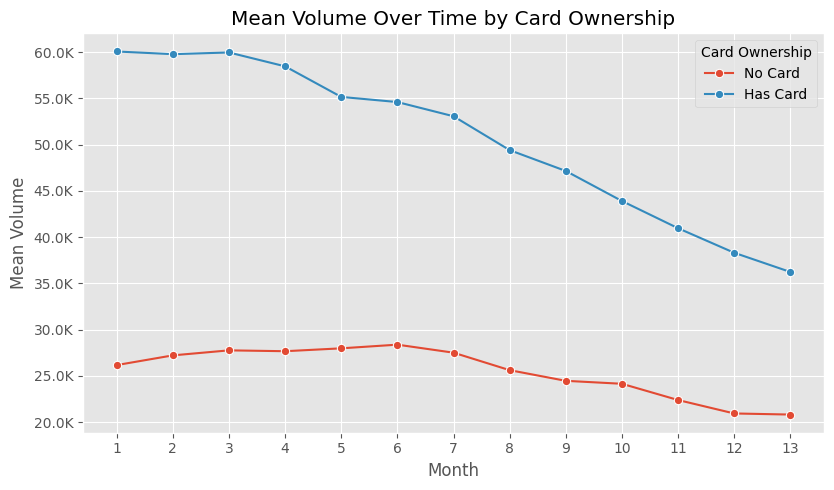

In [53]:
from src.plot_utils import plot_agg_variables

plot_agg_variables(client_df, 'volume', ['mean'])

There are clear and distinct trends in the mean volume for the two groups. Customers who eventually get a card show a decreasing trend in volume over the rollup time, whereas the customers who do not get a card have a relatively stable or only slightly decreasing trend compared to the other group.

The volume in card holders is overall also much higher than for non-card customers over all months in the rollup windows.

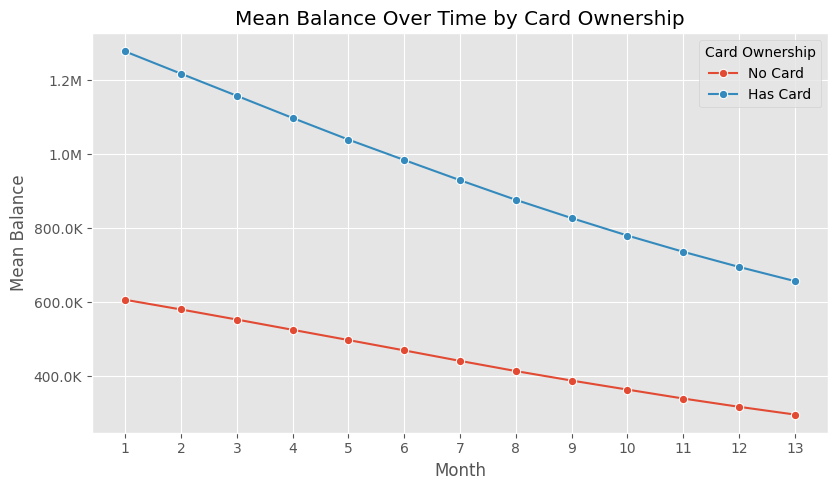

In [54]:
plot_agg_variables(client_df, 'balance', ['mean'])

In comparison the balance shows less structural differences. Both customer groups show linearly decreasing balances across all customers. The customers with cards again appear to have an overall higher mean balance throughout the rollup window.

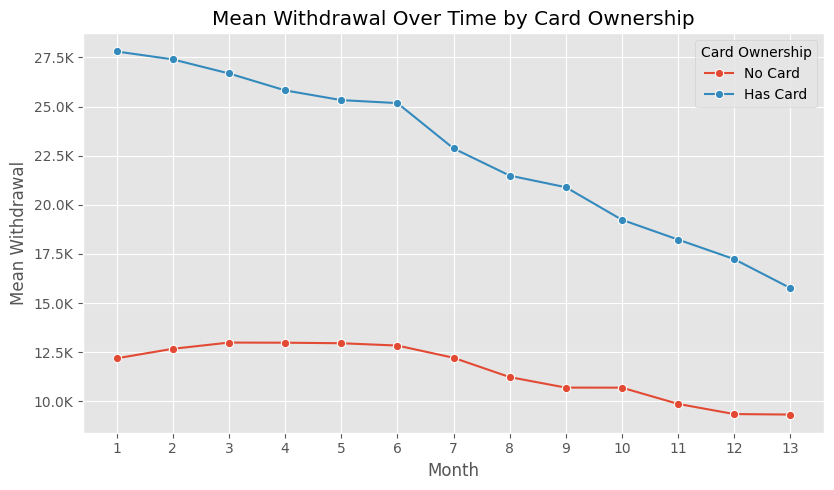

In [55]:
plot_agg_variables(client_df, 'withdrawal', ['mean'])

The comparison between withdrawal for card owners and non-card customers again shows a very similar trend/structure as already observed in the plot for the volume in the rollup window. The card owners' withdrawal decreases linearly while the non-card customers' withdrawal increases during the first 3 months of the rollup window and then starts to decrease as well.

When looking at the range of values for both groups the same difference can be seen again where card owners generally have a higher mean withdrawal in the months before their card issuance.

## <a id='toc1_6_'></a>[Train-Test-Split](#toc0_)

Since we now have added numerous features and finished the preprocessing process the next step will be to split the data into a train and test split before we train the proposed baseline and candidate models on the data.

To split the data a `train_test_split_bal` function was made. This function will randomly undersample the train split into a 50/50 split. This way it can be made sure to train the models without developing a bias towards the majority class but rather to effectively concentrate on the features to predict the card classes.

The test split however does not get undersampled, it will keep the original data's distribution since it can be assumed it represents the actual customer base. If the real-world data is imbalanced, the test set should also be imbalanced to accurately evaluate the model's performance in real-world scenarios.

Later on during training, the models go through 5-Fold Cross Validation which will inherently introduce a validation set of 1/5th of the training set.

The split ratio was set to 80/20; 80% being the the training set size and 20% the test size.

In [56]:
from src.train_utils import train_test_split_bal

cleaned_client_df = client_df.loc[:, ~client_df.columns.str.contains('_id|id_|_date|card_issued|age_bracket|card_type')]

X_train, X_test, y_train, y_test = train_test_split_bal(df=cleaned_client_df, target_column='has_card', test_size=0.2, random_state=1337, balancing_technique='undersample')

In [57]:
print('Train set:')
print(y_train.value_counts(normalize=True))
print('\nTest set:')
print(y_test.value_counts(normalize=True))

Train set:
has_card
False    0.5
True     0.5
Name: proportion, dtype: float64

Test set:
has_card
False    0.792732
True     0.207268
Name: proportion, dtype: float64


As intended, the class distribution is balanced on the train set but the test set's distribution stays unchanged and roughly represents the real world data.

## <a id='toc1_7_'></a>[Baseline Model](#toc0_)

The baseline model should be used as a base for comparison for future model candidates.

The baseline model only models the `has_card` class based on the following features:
- Client Age
- Gender
- Client's District Region
- Volume before Card Issuance (Volume Rollup Window)
- Balance before Card Issuance (Balance Rollup Window)

The data will first go through a preprocessing pipeline where it gets standard-scaled, categorical variables will get one-hot-encoded and missing values get imputed by the column's mean. This preprocessing pipeline is constructed with the `build_preprocessor_pipeline` function. To build a preprocessing pipeline custom feature columns can be passed into the function either through the column names or by a regex which is especially useful for the monthly rollup window columns. This function will not only be used for the baseline model but also for all further model candidates.

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 257.50it/s]


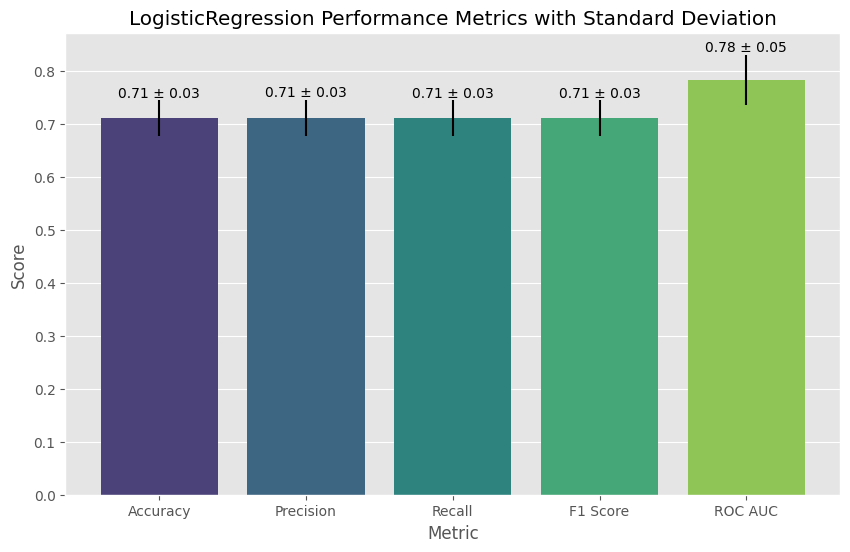

In [58]:
from src.plot_utils import (plot_model_evaluation_summary, 
                            plot_confusion_matrix, 
                            plot_lift_curve, 
                            plot_precision_recall_curve, 
                            plot_metrics,
                            plot_param_grid_heatmap)

from src.train_utils import (cross_validate,
                             build_preprocessor_pipeline)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

baseline_columns = ['client_age', 'client_gender', 'client_district_region']

baseline_preprocessor, baseline_column_selection = build_preprocessor_pipeline(X_train, 
                                                                               include_columns=baseline_columns, 
                                                                               regex_columns='(volume|balance)')

base_pipeline = Pipeline([
    ('preprocessor', baseline_preprocessor),
    ('classifier', LogisticRegression(random_state=1337, max_iter=10_000))
])

(base_estimator, 
 base_params, 
 base_metrics_df, 
 base_roc_curves, 
 base_pr_curves, 
 base_lift_probs, 
 base_true_labels,
 _) = cross_validate(base_pipeline, 
                     baseline_column_selection, 
                     y_train)

model_name = base_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(base_metrics_df, model_name)

The simple baseline logistic regression model shows relatively consistent performance across the different metrics, with accuracy, precision, recall, and F1 score all at 71% with 3% standard deviation across the 5 folds. The ROC/AUC is slightly higher at 78%, indicating a reasonably good classification performance. The standard deviations indicate that there is some variability in these metrics, but they remain relatively stable.

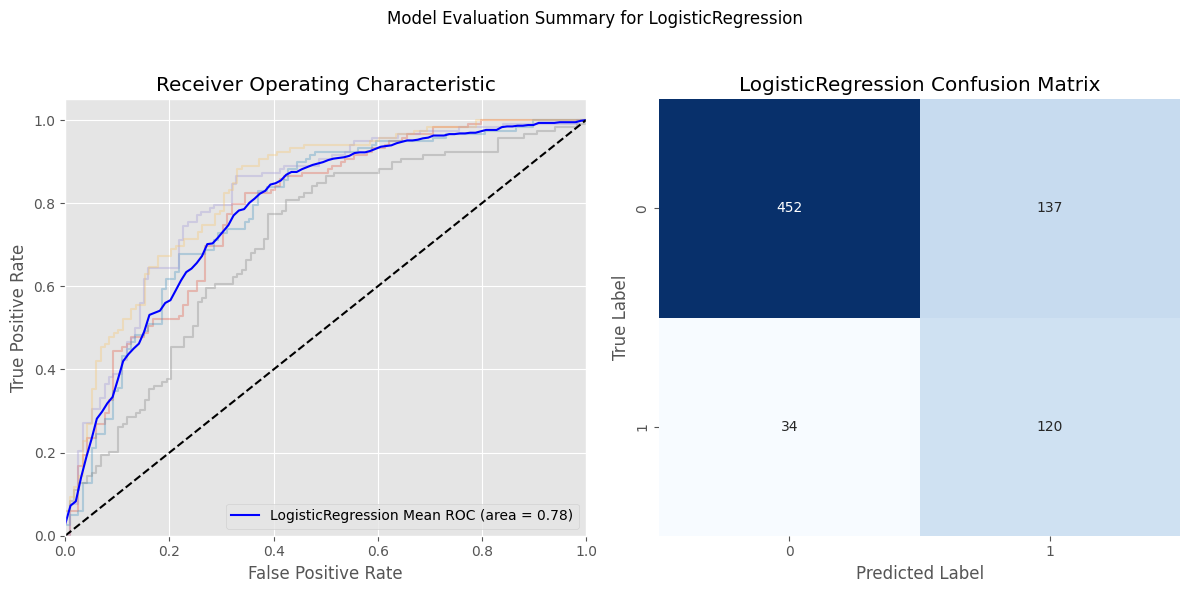

In [59]:
plot_model_evaluation_summary(base_roc_curves, base_metrics_df.mean(), base_estimator, X_test[baseline_column_selection.columns], y_test, model_name)

The baseline model demonstrates a good discriminative ability on the validation set with an ROC AUC of 0.78. This indicates that the model is effective at distinguishing between positive and negative cases.

The confusion matrix shows that the model has a balanced performance with:
- Accuracy: A high number of true positives and true negatives contribute to the overall accuracy.
- Precision and Recall: The model maintains consistent performance, as indicated by the balanced number of false positives and false negatives.

## <a id='toc1_8_'></a>[Further Model Candidates](#toc0_)

Since we now have the baseline model set up, lets explore further candidate models that aren't restricted when it comes to variable selection.

To construct further candidate models all variables are used to train the further candidates. In an optimal case it would make sense to perform feature selection for each model independently though this is very compute intensive so every candidate just gets cross validated on the dataset with all features. Additionally a grid search is performed to find suitable parameters that help the models perform better.

After exploring numerous candidates, a comparison will be made to "crown" a final model. The final model will then go through a feature selection process using Recursive Feature Elimination (RFE) on the 100 most important variables according to dropout loss.

### <a id='toc1_8_1_'></a>[Logistic Regression](#toc0_)

The first model candidate is also a Logistic Regression model but without any constraints on number of features.

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 4794.59it/s]


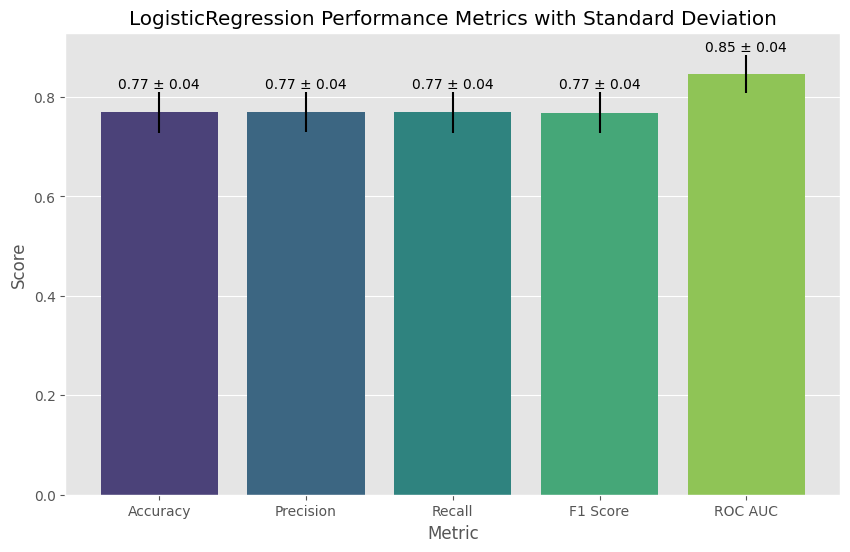

In [60]:
all_vars_prep_pipeline, all_vars_column_selection  = build_preprocessor_pipeline(X_train, include_columns=X_train.columns.tolist())

lr_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', LogisticRegression(random_state=1337, max_iter=100_000, solver='saga'))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

(lr_estimator,
 lr_params,
 lr_metrics_df,
 lr_roc_curves,
 lr_pr_curves,
 lr_lift_probs,
 lr_true_labels,
 lr_grid_search) = cross_validate(lr_pipeline, all_vars_column_selection, y_train, param_grid=lr_param_grid)

model_name = lr_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(lr_metrics_df, model_name)

The logistic regression model that includes all variables shows better performance compared to the baseline model. The improvements in accuracy, precision, recall, F1 score, and ROC AUC could be due to including all features.

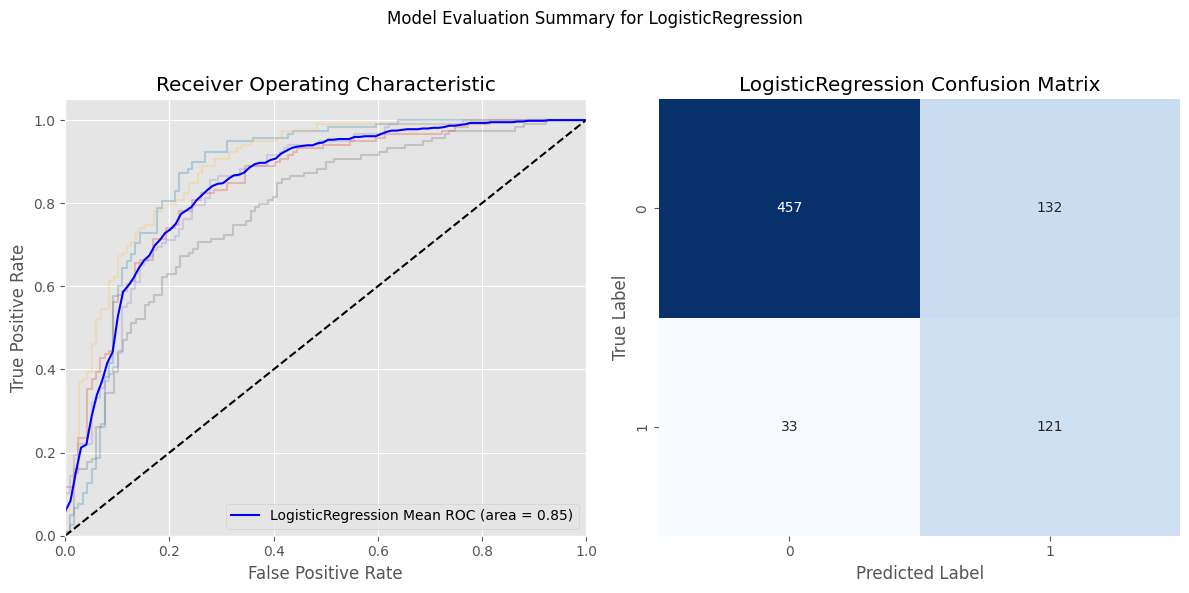

In [61]:
plot_model_evaluation_summary(lr_roc_curves, lr_metrics_df.mean(), lr_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

The logistic regression model with all variables yields a better discriminative ability on the validation set with an ROC AUC of 0.85. This is quite a large improvement compared to the baseline model.

The confusion matrix however doesn't show much of an improvement. The confusion matrix is calculated on the test set while the ROC curve is calculated on the validation set, hence we start to overfit on the validation set and don't really improve much more on the test set.

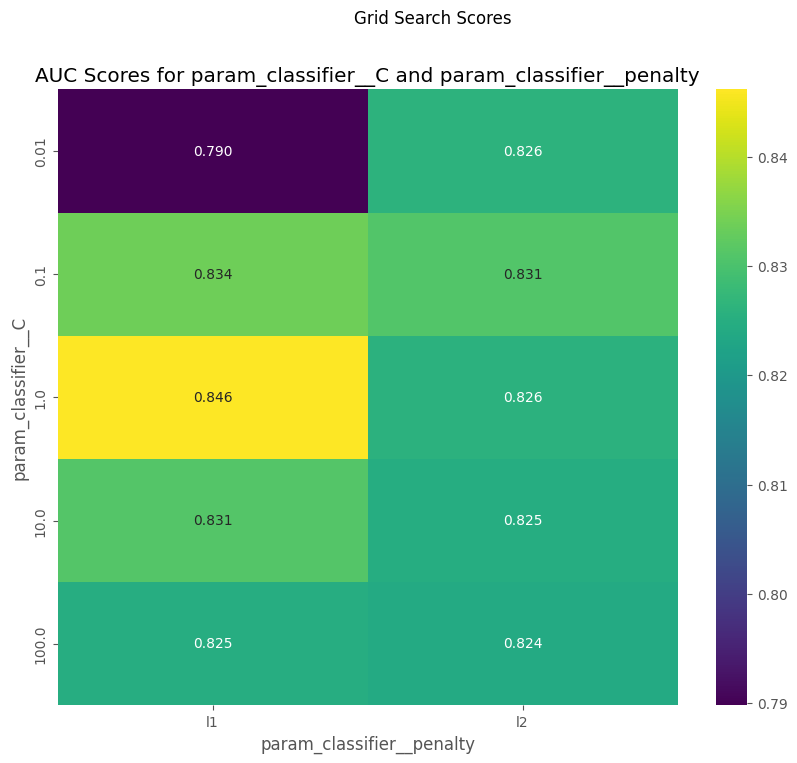

In [62]:
plot_param_grid_heatmap(lr_grid_search)

The `GridSearchCV` identified the best hyperparameters for the logistic regression model based on the AUC values. The optimal combination found is a regularization parameter `C` of `1.0` with an L1 penalty, achieving the highest AUC score of `0.846`.

### <a id='toc1_8_2_'></a>[Decision Tree](#toc0_)

The decision tree also gets fit on all variables.

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 5440.08it/s]


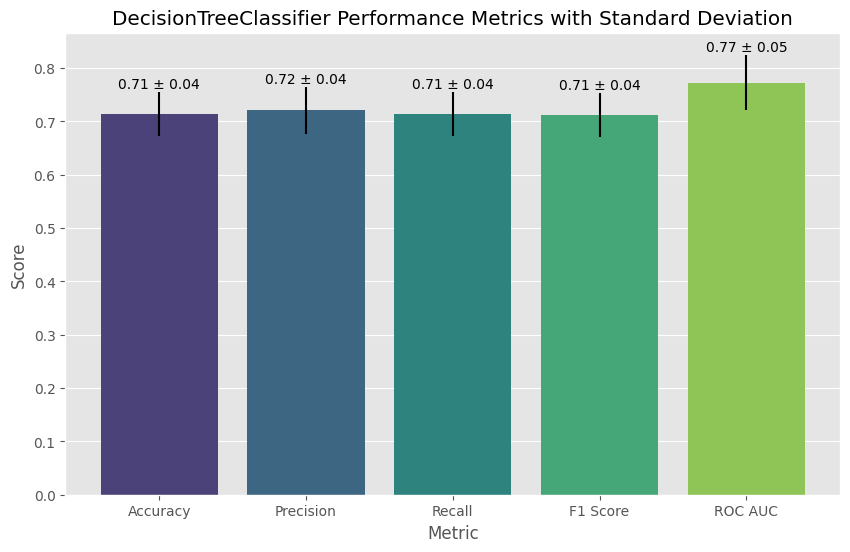

In [63]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=1337))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, 20, 30, 50],
    'classifier__min_samples_split': [5, 10, 20, 30, 50]
}

(dt_estimator, 
 dt_params, 
 dt_metrics_df, 
 dt_roc_curves, 
 dt_pr_curves, 
 dt_lift_probs, 
 dt_true_labels,
 dt_grid_search) = cross_validate(pipeline=dt_pipeline, 
                                  X=all_vars_column_selection, 
                                  y=y_train,
                                  param_grid=dt_param_grid)

model_name = dt_estimator.named_steps['classifier'].__class__.__name__
plot_metrics(dt_metrics_df, model_name)

The Decision Tree Classifier performs consistently across different metrics, but overall with lower scores compared to both the baseline Logistic Regression and the extended Logistic Regression models.

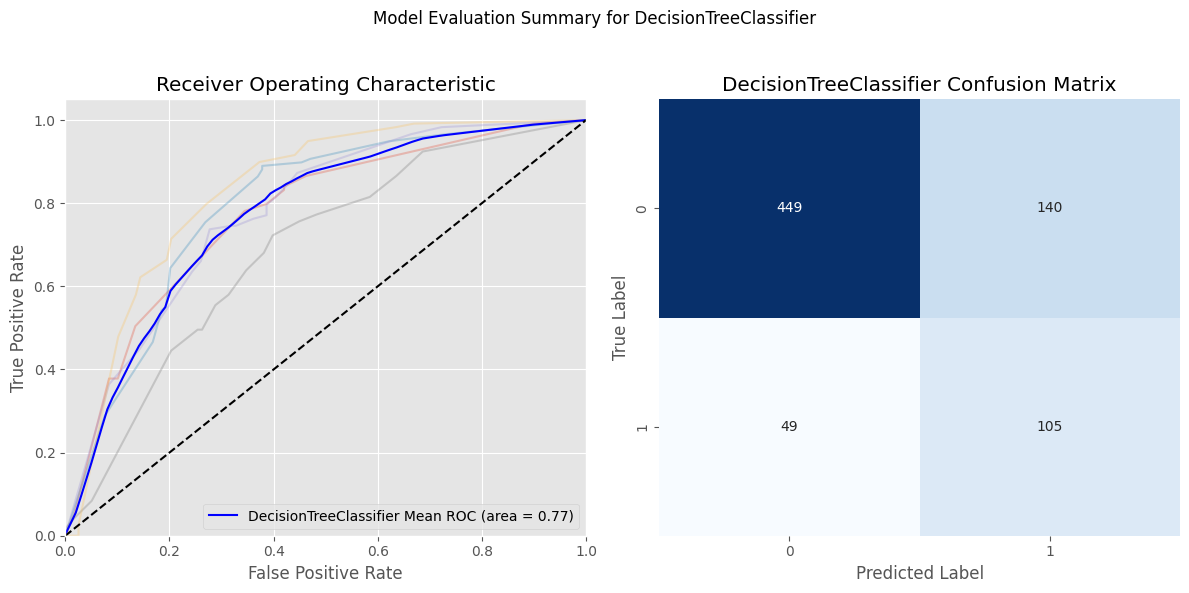

In [64]:
plot_model_evaluation_summary(dt_roc_curves, dt_metrics_df.mean(), dt_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

The confusion matrix reveals that the model correctly identifies a substantial number of positive and negative cases in the test set but it still performs worse compared to the previously explored models. Both the True Positives and the True Negatives decreased while the False Positives and False Negatives increased a slight bit.

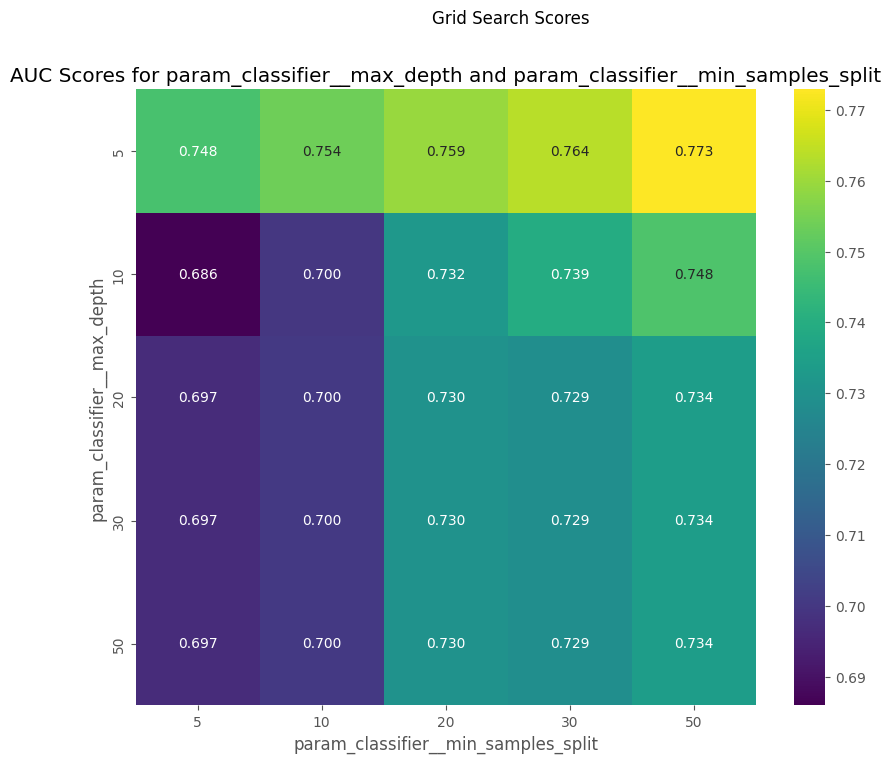

In [65]:
plot_param_grid_heatmap(dt_grid_search)

The grid search results show that the Decision Tree performs better with shallower trees and stricter splitting criteria.

### <a id='toc1_8_3_'></a>[Random Forest](#toc0_)

Since the Decision Tree came out to be worse than the models before, the Random Forest candidate will explore if a more complex architecture of essentially multiple Decision Trees can fit the data in an improved way.

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 4960.15it/s]


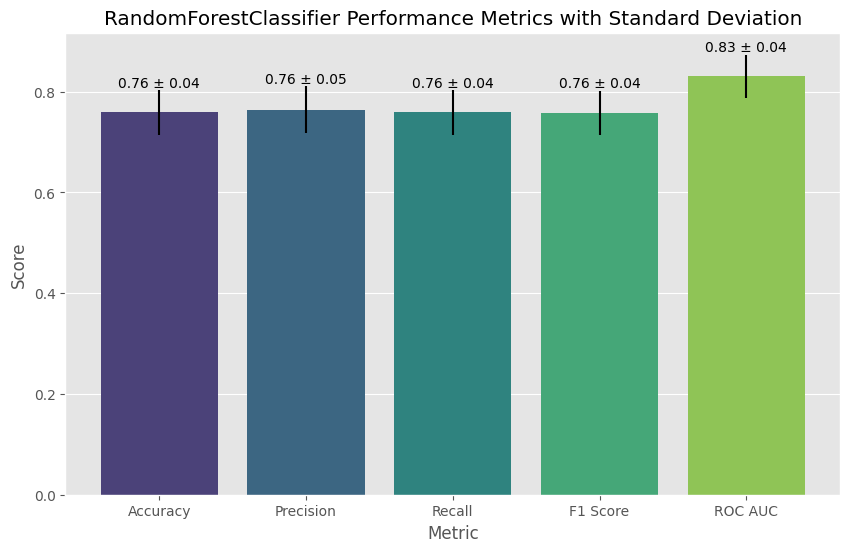

In [66]:
from sklearn.ensemble import RandomForestClassifier

all_vars_prep_pipeline, all_vars_column_selection = build_preprocessor_pipeline(X_train, include_columns=X_train.columns.tolist())

rf_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', RandomForestClassifier(random_state=1337))
])

rf_param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_features': ['sqrt', 'log2']
}

(rf_estimator, 
 rf_params, 
 rf_metrics_df, 
 rf_roc_curves, 
 rf_pr_curves, 
 rf_lift_probs, 
 rf_true_labels,
 rf_grid_search) = cross_validate(rf_pipeline, 
                                  X_train[all_vars_column_selection.columns], 
                                  y_train, 
                                  param_grid=rf_param_grid)

model_name = rf_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(rf_metrics_df, model_name)

As hypothesized, the Random Forest performs better than the Decision Tree, hoever, the Logistic Regression approach can still not be beaten when comparing the metrics.

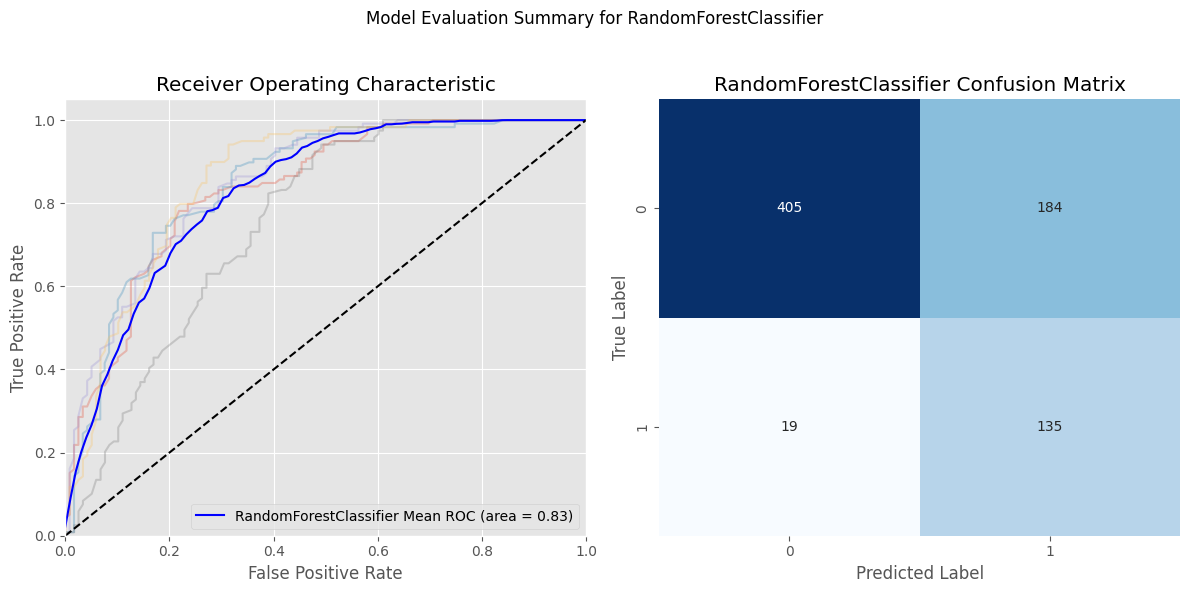

In [67]:
plot_model_evaluation_summary(rf_roc_curves, rf_metrics_df.mean(), rf_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

The ROC curve shows fairly stable cross validation with just one fold performing significantly worse. The confusion matrix on the test set shows an interesting change: The False Negatives decreased compared to the Logistic Regression while the False Positives increased.

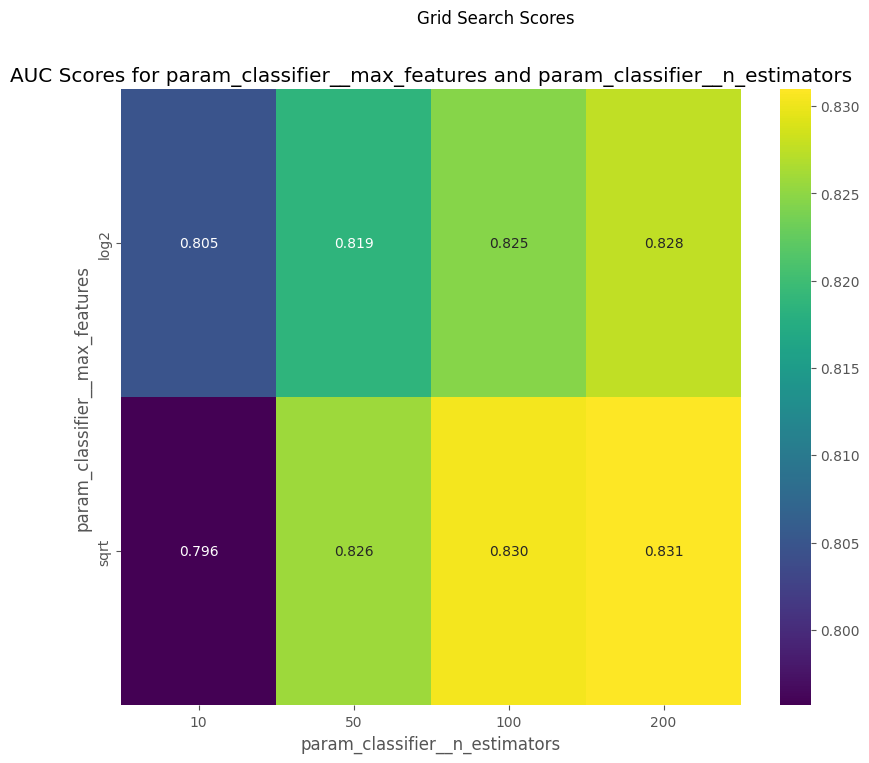

In [68]:
plot_param_grid_heatmap(rf_grid_search)

The grid search results imply that the Random Forest benefits from a higher number of estimators, which makes sense since we add more variance in the bias-variance-tradeoff. The `max_features` parameter only had a slight impact on the outcome of the AUC score whereby the square root of the features seems to have been the "best" parameter.

### <a id='toc1_8_4_'></a>[Bagging](#toc0_)

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 5599.87it/s]


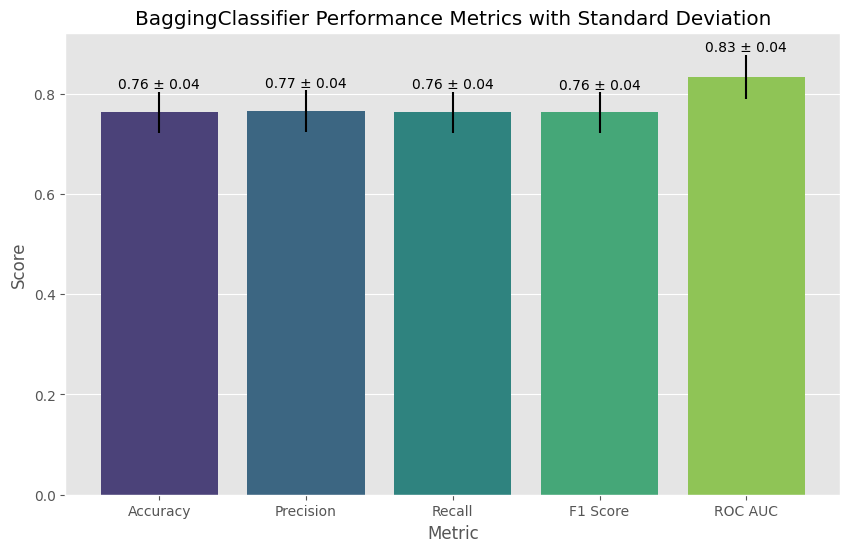

In [69]:
from sklearn.ensemble import BaggingClassifier

bg_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', BaggingClassifier(random_state=1337))
])

bg_param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_samples': [0.5, 0.7, 1.0]
}

(bg_estimator, 
 bg_params, 
 bg_metrics_df, 
 bg_roc_curves, 
 bg_pr_curves, 
 bg_lift_probs, 
 bg_true_labels,
 bg_grid_search) = cross_validate(bg_pipeline,
                                  all_vars_column_selection, 
                                  y_train, 
                                  param_grid=bg_param_grid)

model_name = bg_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(bg_metrics_df, model_name)

The Bagging Classifier achieves roughly the same metrics as the Logistic Regression model, though it still cannot reach the benchmark when comparing the AUC score.

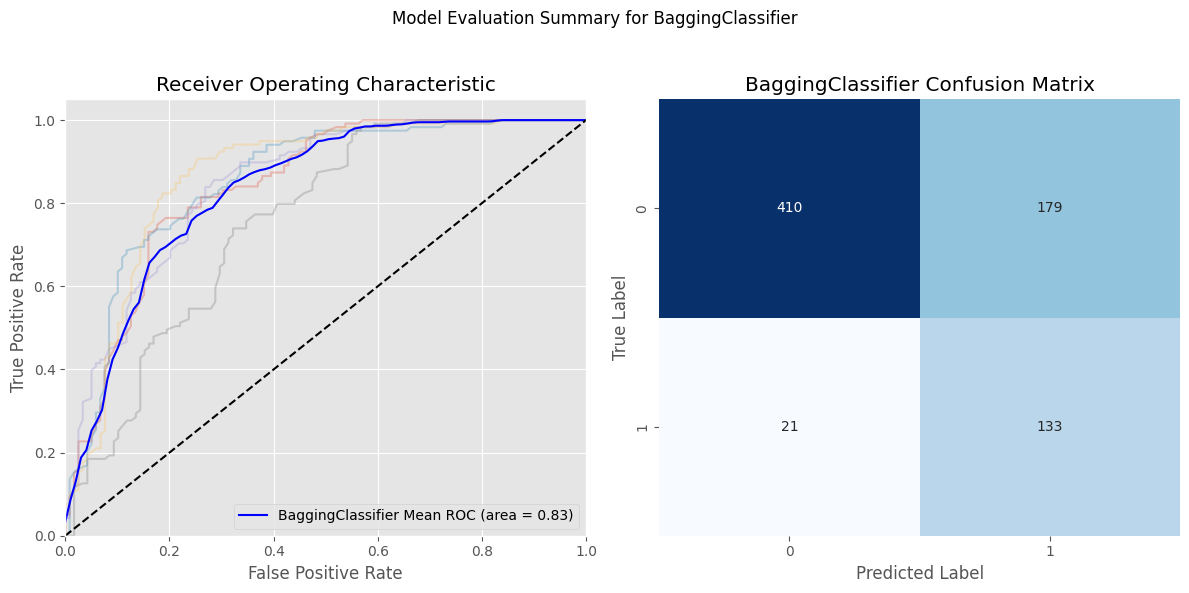

In [70]:
plot_model_evaluation_summary(bg_roc_curves, bg_metrics_df.mean(), bg_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

Also the same phenomenon as in the Random Forest already observed can be seen. The False Negatives decrease in comparison while the False Positives increase by a noticable margin.

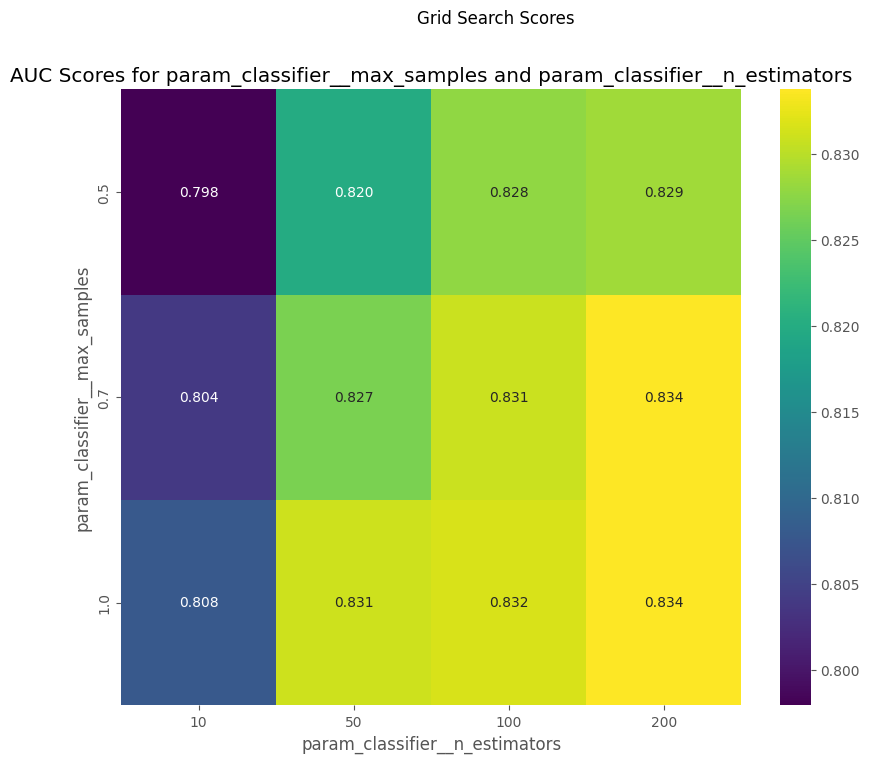

In [71]:
plot_param_grid_heatmap(bg_grid_search)

The param grid visualization clearly shows that the Bagging Classifier benefits from added model complexity. The best AUC score was reached with `200` estimators and all features.

### <a id='toc1_8_5_'></a>[Boosting](#toc0_)

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 6082.23it/s]


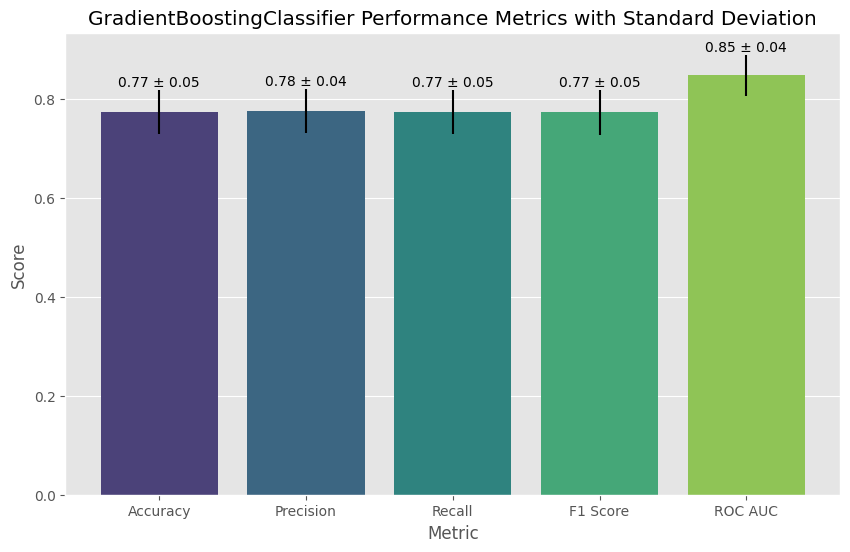

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

bt_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=1337))
])

bt_param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.5]
}

(bt_estimator, 
 bt_params, 
 bt_metrics_df, 
 bt_roc_curves, 
 bt_pr_curves, 
 bt_lift_probs, 
 bt_true_labels,
 bt_grid_search) = cross_validate(bt_pipeline,
                                  all_vars_column_selection, 
                                  y_train, 
                                  param_grid=bt_param_grid)

model_name = bt_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(bt_metrics_df, model_name)

The Gradient Boosting Classifier reached slightly better benchmarks compared to the Logistic Regression Model within the metrics Accuracy, Precision, Recall and F1. The AUC score is on par with the previous best model.

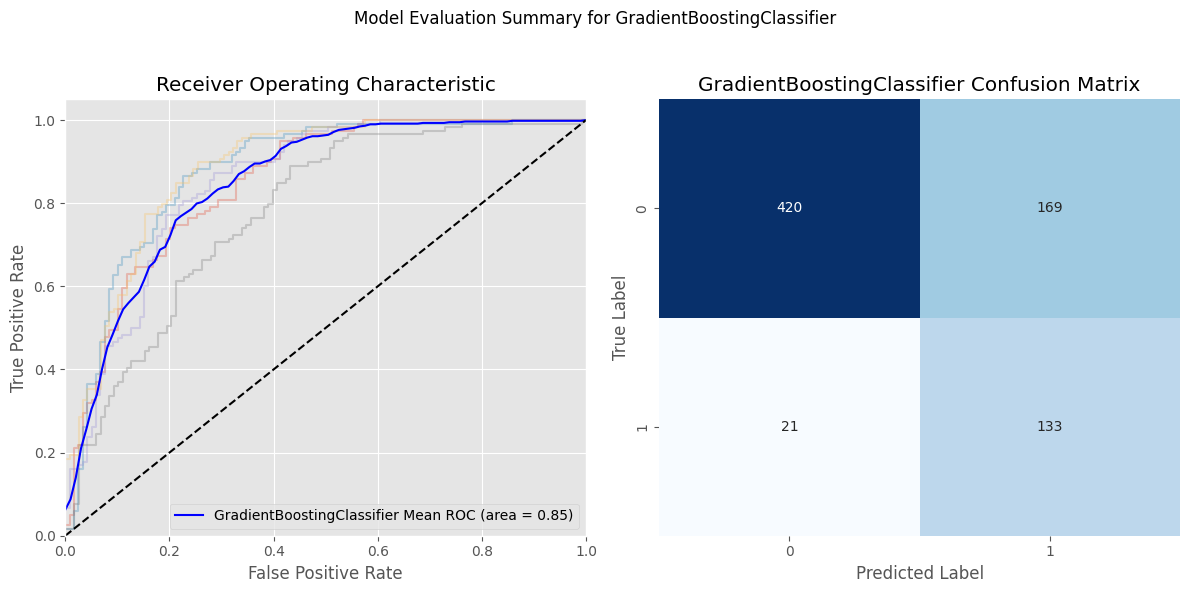

In [73]:
plot_model_evaluation_summary(bt_roc_curves, bt_metrics_df.mean(), bt_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

The evaluation summary plot also shows the improvement, especially on the confusion matrix which was caluclated on the test set. Both the False False Positives and False Negatives decreased compared to the other ensemble models though compared to the extended Logistic Regression's results the performance still seems worse on the test set. This indicates that the Boosting Classifier is clearly starting to overfit on the training and validation set.

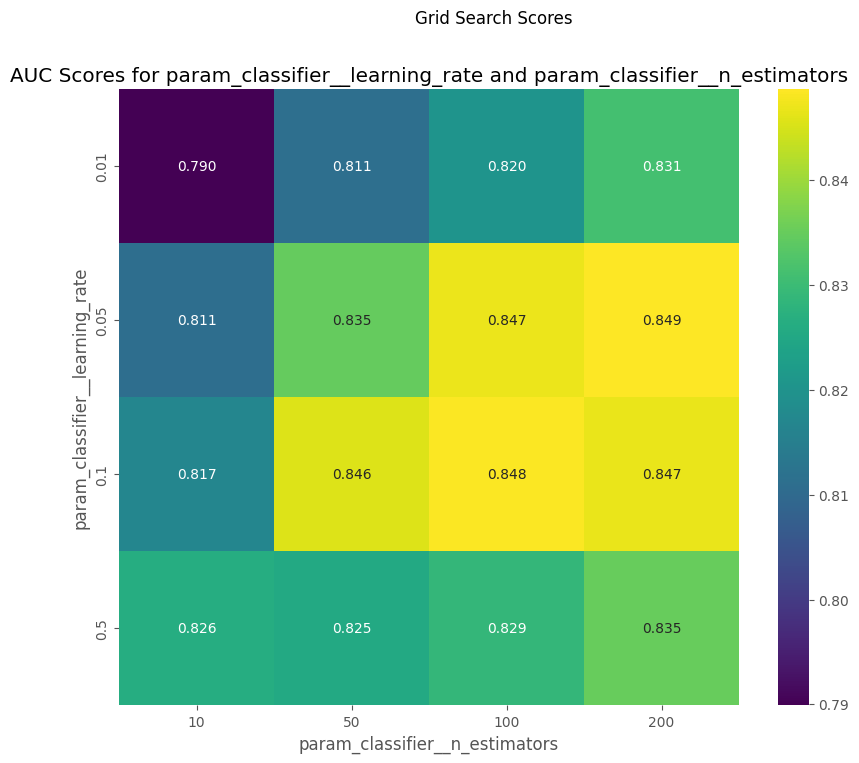

In [74]:
plot_param_grid_heatmap(bt_grid_search)

The plot showing the results of the param grid combinations shows that the model works best with a learning rate at around `0.1` and starts to overshoot the minima at `0.5`. And similar to the observations on the previous ensemble models, as expected, this Boosting Classifier also benefits from more complexity where it reaches the best AUC score at a complexity of `200` estimators.

## <a id='toc1_9_'></a>[Comparing the Model Candidates](#toc0_)

In this chapter the trained candidates get compared to each other so that at the end a "best" model can be determined to further improve upon.

### <a id='toc1_9_1_'></a>[ROC Curves](#toc0_)

The first comparing analysis will be in the context of TP and FP rates (ROC Curves).

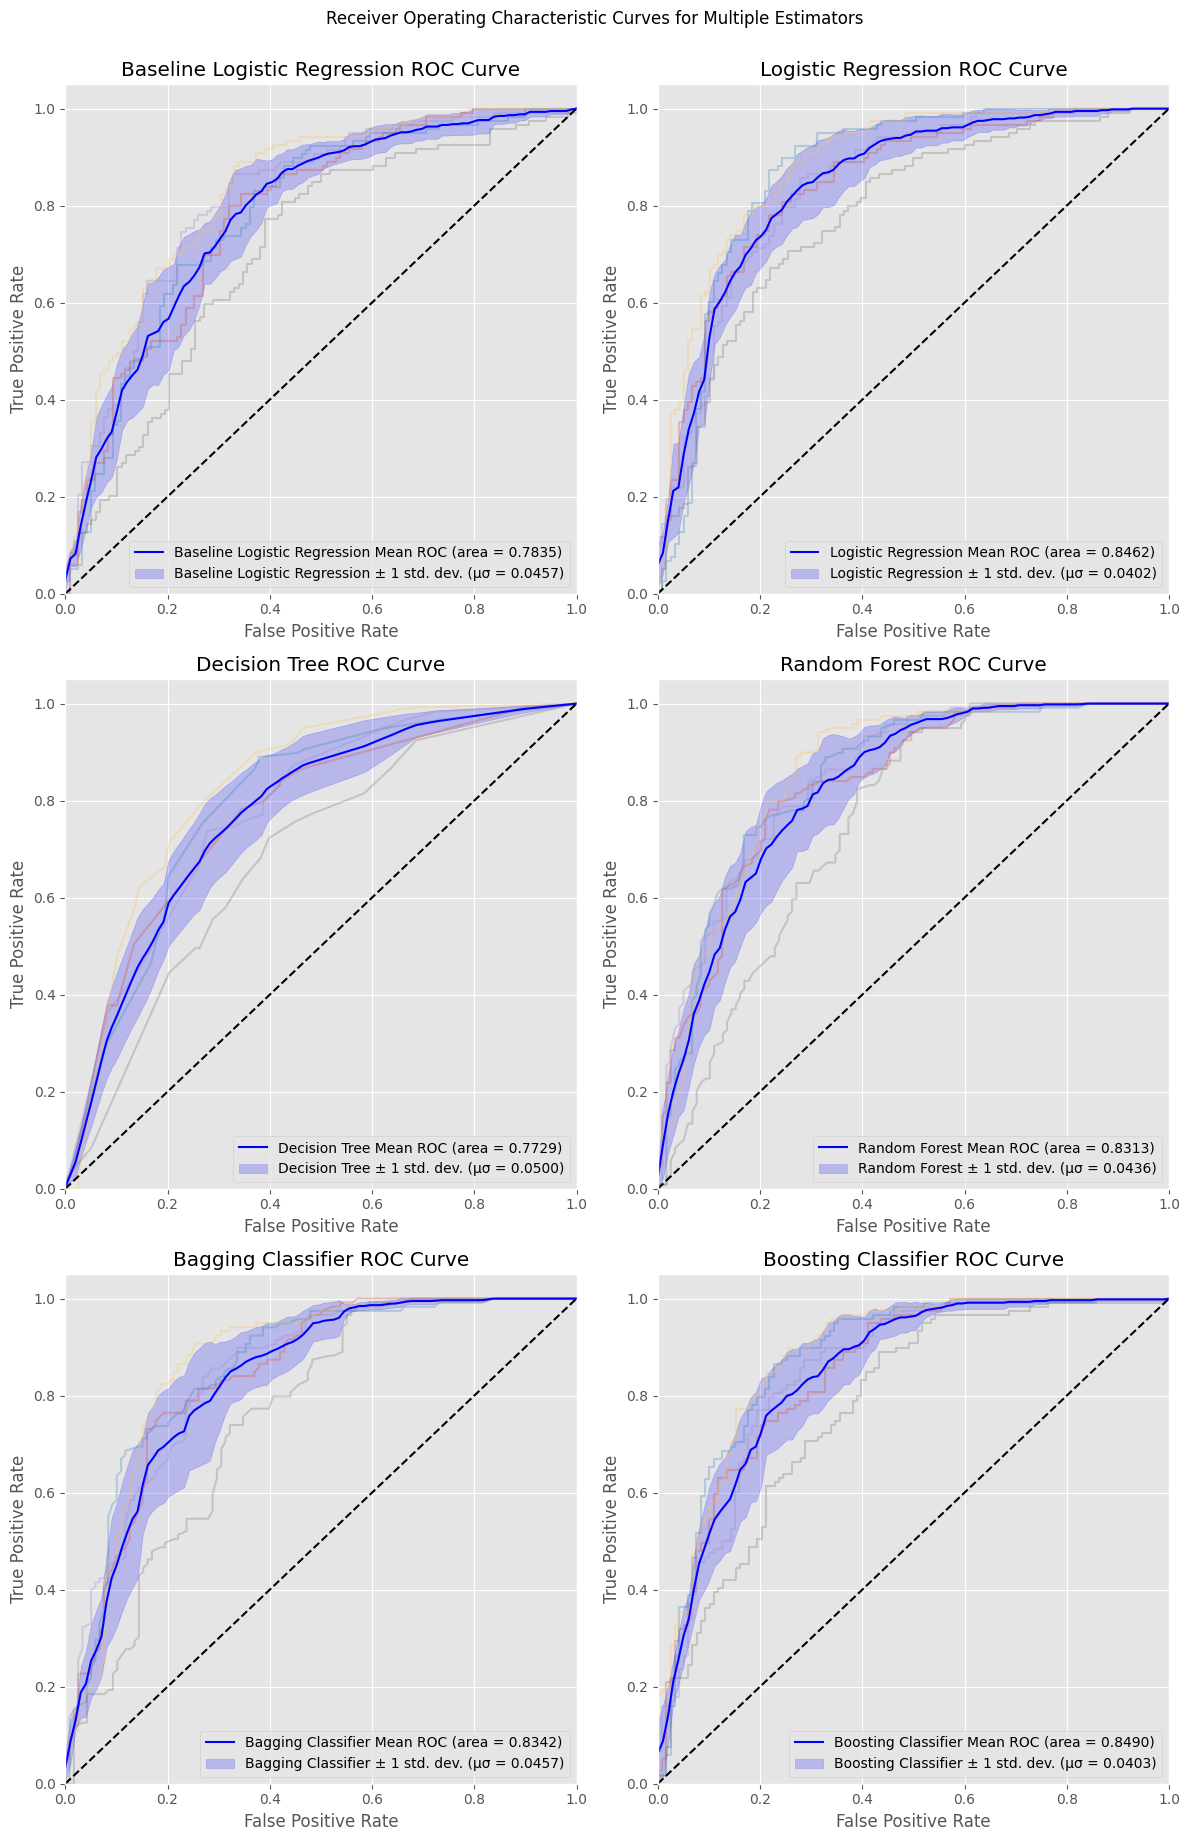

In [75]:
from src.plot_utils import plot_multiple_roc_curves

plot_multiple_roc_curves([base_roc_curves, lr_roc_curves, dt_roc_curves, rf_roc_curves, bg_roc_curves, bt_roc_curves], 
                         ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

The Boosting Classifier reached the highest AUC score of `0.8486` (84.86%) with the lowest standard deviation measured across the 5-fold Cross Validation.

The Tree-Based Ensemble models show an interesting pattern in the ROC curve. This could be due to the fact that these models typically are a step function because Decision Trees predict class labels directly without providing probability estimates. This means that the classifier can only predict a fixed set of thresholds, resulting in a stepwise ROC curve rather than a fine curve.

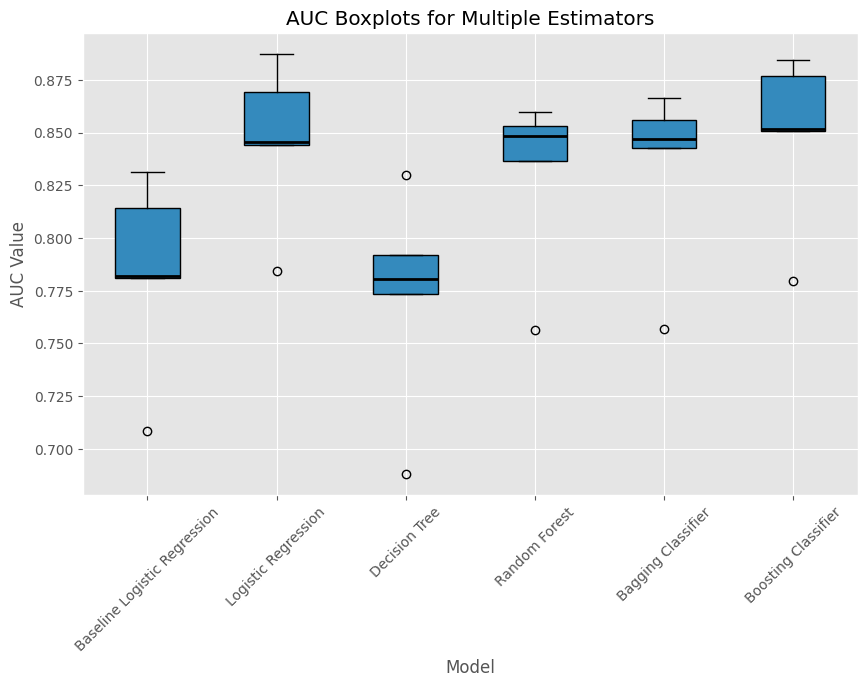

In [76]:
from src.plot_utils import plot_auc_boxplots

plot_auc_boxplots([base_roc_curves, lr_roc_curves, dt_roc_curves, rf_roc_curves, bg_roc_curves, bt_roc_curves], 
                  ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

Overall when looking at the distribution of the reached AUC scores for all models, the extended Logistic Regression (with all variables) reached the highest scores in the 5 folds compared to the Boosting Classifier.

### <a id='toc1_9_2_'></a>[Confusion Matrices](#toc0_)

To compare the performance on the test set for the candidates, the following plot shows all confusion matrices.

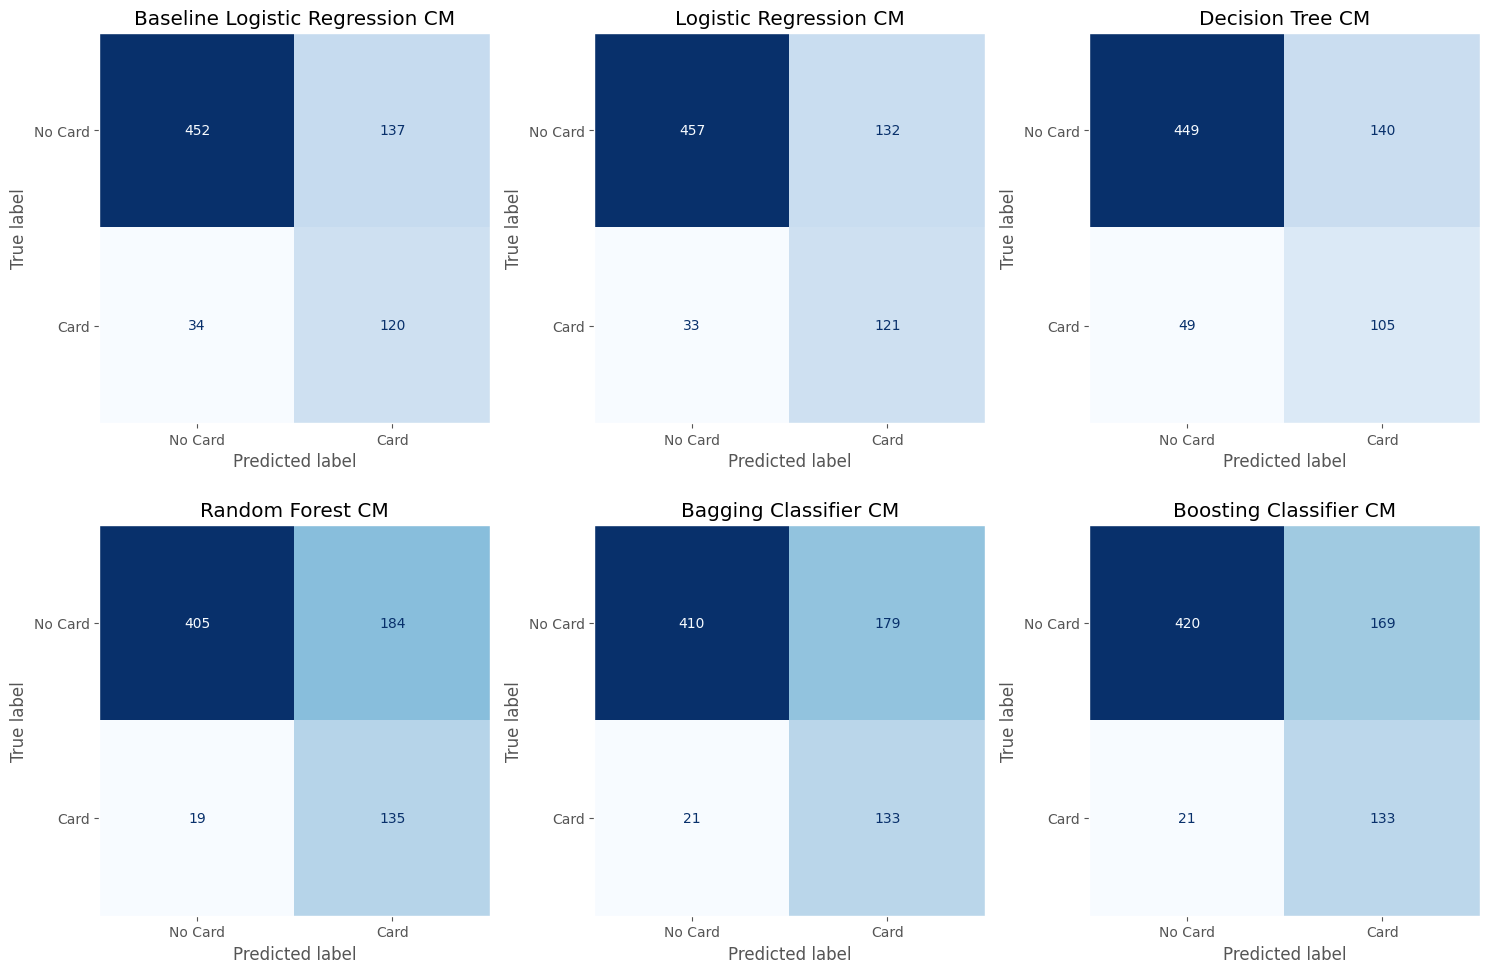

In [77]:
from src.plot_utils import plot_confusion_matrices

plot_confusion_matrices([base_estimator, lr_estimator, dt_estimator, rf_estimator, bg_estimator, bt_estimator], 
                        X_test[all_vars_column_selection.columns], 
                        y_test,
                        ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

The two best performing models across the board seem to be the Boostin Classifier and the Logistic Regression with all available features. An observation was that the Boosting Classifier overfits slightly on the True Positives and the Logistic Regression might overfit slightly on the True Negatives.

### <a id='toc1_9_3_'></a>[Other Metrics](#toc0_)

In [78]:
average_metrics = []

for name, df in zip(['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'], 
                    [base_metrics_df, lr_metrics_df, dt_metrics_df, rf_metrics_df, bg_metrics_df, bt_metrics_df]):
    mean_metrics = df.mean()
    mean_metrics['Estimator'] = name
    average_metrics.append(mean_metrics)

average_metrics_df = pd.DataFrame(average_metrics)[['Estimator', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

average_metrics_df

Estimator  Accuracy  Precision    Recall  F1 Score  \
0  Baseline Logistic Regression  0.710797   0.711504  0.710797  0.710601   
1           Logistic Regression  0.768968   0.769728  0.768968  0.768752   
2                 Decision Tree  0.714172   0.720616  0.714172  0.712326   
3                 Random Forest  0.758845   0.763921  0.758845  0.757804   
4            Bagging Classifier  0.763068   0.765643  0.763068  0.762508   
5           Boosting Classifier  0.774045   0.777111  0.774045  0.773304   

    ROC AUC  
0  0.783406  
1  0.846167  
2  0.772888  
3  0.830956  
4  0.833745  
5  0.848636

### <a id='toc1_9_4_'></a>[Top Customer Lists](#toc0_)

To also see how the model candidates might agree on the overall most certain customers, the following subsection shows the overlap of prediction outcomes between all candidates once for the top 5% and once for the top 10% of customers.

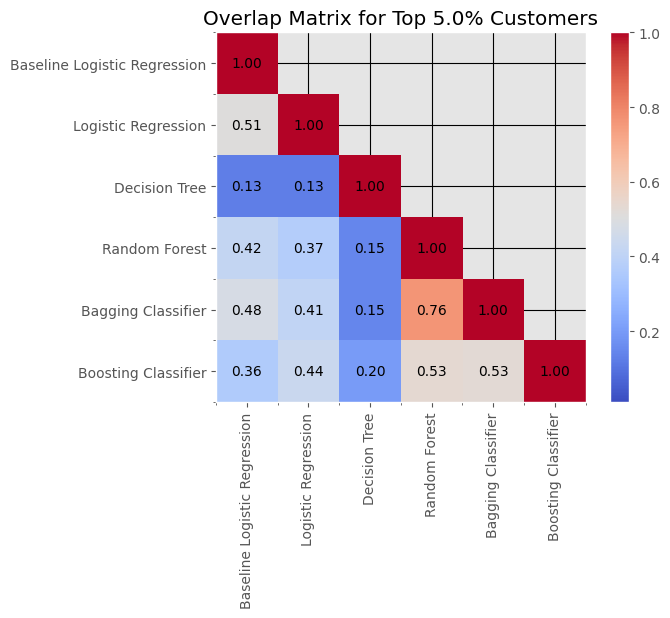

In [93]:
from src.plot_utils import plot_model_concordance

estimators = [base_estimator, lr_estimator, dt_estimator, rf_estimator, bg_estimator, bt_estimator]
estimator_names = ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier']
non_card_holders = cleaned_client_df[cleaned_client_df['has_card'] == False].drop(columns='has_card')

plot_model_concordance(estimators, estimator_names, non_card_holders, p=0.05)

For the top 5% customers, there seems to be some overlap or agreement between the baseline Logistic Regression and the extended Logistic Regression models. Another area with more agreement is between the ensemble models (Boosting, Bagging and Random Forest classifiers). The highest overlap can be reached between the Random Forest and Bagging Classifier.

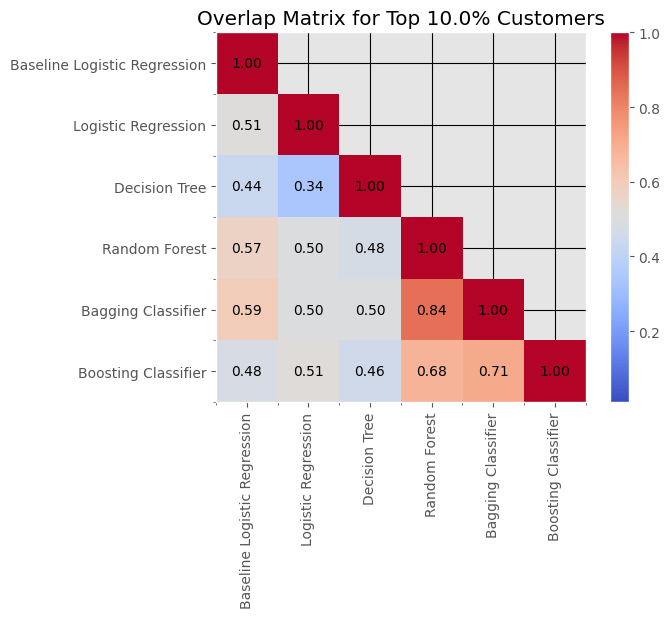

In [94]:
plot_model_concordance(estimators, estimator_names, non_card_holders, p=0.1)

Adding another 5% on top of the smaller subset seems to overall raise the agreement between all models except between the extended Logistic Regression and baseline Logistic Regression models where the overlap almost shows the same percentage. Especially the ensemble models reach a high overlap. I suspect the higher overlap between these models to be due to their architecture: Models that are part of ensemble methods like Bagging or Boosting are designed to improve predictive accuracy by combining multiple models' predictions. For instance, the Bagging Classifier and Random Forest both use bagging techniques, which could explain their higher overlap.

### <a id='toc1_9_5_'></a>[Choosing a Final Model](#toc0_)

To now crown a final "winner model", I suggest choosing the extended Logistic Regression. The natural data distribution heavily overweighs with customers without cards; The Logistic Regression model also succeeds the best in classifying that majority class so in hindsight of lowering the cost of "falsely" advertising to customers, this model's confusion matrix seems to minimize that potential advertisement cost.

## <a id='toc1_10_'></a>[Model Reduction](#toc0_)

With the Logistic Model now in place, the chosen model at hand will first be reduced to help the explainability and interpretability. A model's performance can also suffer under high feature complexity so this step will try to optimize the required amount of features.

### <a id='toc1_10_1_'></a>[Selecting Features](#toc0_)

Since the Recursive Feature Elimination itself can be computationaly very heavy, only the top 50 features (according to `dalex`'s dropout loss) will be reduced by RFE.

The Dropout Loss essentially measures the change in loss whenever the respective variable is "dropped out" or just left out from fitting. The more meaningful a variable is for a model's predictions, the higher its dropout loss value is. Looking at just variable importance (i.e. Dropout Loss) is not inherently the best approach feature selection since it neglects the potential importance of interacting variables. This is where RFE comes in. RFE will also put emphasis on the interaction between variables when selecting "important" features.

In [79]:
from dalex import Explainer

lr_explainer = Explainer(lr_estimator, X_train[all_vars_column_selection.columns], y_train, label='Logistic Regression')

lr_model_parts = lr_explainer.model_parts(type='variable_importance')

lr_top_variables = lr_model_parts.result.sort_values('dropout_loss', ascending=False).head(51)[['variable', 'dropout_loss']]
lr_top_variables = lr_top_variables[lr_top_variables['variable'] != '_baseline_']

lr_top_variables

Preparation of a new explainer is initiated

  -> data              : 1186 rows 233 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1186 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic Regression
  -> predict function  : <function yhat_proba_default at 0x29c922ca0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000127, mean = 0.5, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.98, mean = -3.87e-05, max = 0.868
  -> model_info        : package sklearn

A new explainer has been created!


variable  dropout_loss
233            pre_card_credit_mean      0.303514
232             credit_month_diff_7      0.280006
231             credit_month_diff_9      0.218071
230             credit_month_diff_6      0.197614
229               credit_month_mean      0.193826
228     pre_card_n_transactions_sum      0.187998
227                credit_month_sum      0.187252
226                credit_month_max      0.166707
225             volume_month_diff_7      0.164795
224             volume_month_diff_9      0.151570
223               balance_month_std      0.144832
222             volume_month_diff_6      0.141864
221    pre_card_n_transactions_mean      0.140690
220         credit_last_quarter_std      0.140570
219             pre_card_volume_std      0.139945
218         volume_last_quarter_max      0.132605
217        n_transactions_month_min      0.132325
216                volume_month_std      0.122966
215             credit_month_diff_8      0.120589
214               volume_month_mean      0.119929
213                volume_month_sum      0.119134
212             credit_month_diff_5      0.114507
211             credit_month_diff_4      0.109794
210             credit_month_median      0.109789
209        n_transactions_month_max      0.109150
208                     account_age      0.108561
207             credit_month_diff_3      0.108317
206             volume_month_median      0.107461
205     volume_first_quarter_median      0.105405
204             pre_card_credit_sum      0.105006
203         withdrawal_month_diff_8      0.103334
202            credit_month_diff_11      0.094544
201         volume_last_quarter_std      0.092954
200         withdrawal_month_diff_5      0.092878
199             volume_month_diff_5      0.092126
198             pre_card_volume_min      0.089352
197        n_transactions_month_std      0.088932
196            volume_month_diff_11      0.087723
195         withdrawal_month_diff_9      0.086668
194     credit_first_quarter_median      0.086437
193                credit_month_std      0.086296
192            withdrawal_month_max      0.085812
191  pre_card_n_transactions_median      0.084848
190             volume_month_diff_4      0.084675
189     n_transactions_month_diff_7      0.084351
188         withdrawal_month_diff_1      0.083861
187     pre_card_n_transactions_min      0.081967
186            withdrawal_month_min      0.081871
185    n_transactions_month_diff_13      0.080430
184     n_transactions_month_diff_5      0.079018

Now with the top 50 features selected, a new preprocessor pipeline will be constructed that contains transformations in the context of those variables.

In [81]:
lr_top_vars_prep_pipeline, lr_top_vars_prep_selection = build_preprocessor_pipeline(X_train, include_columns=X_train[lr_top_variables['variable']].columns.tolist())

lr_rfe_pipeline = Pipeline([
    ('preprocessor', lr_top_vars_prep_pipeline),
    ('classifier', LogisticRegression(**lr_estimator.named_steps['classifier'].get_params()))
])

(lr_rfe_estimator,
 lr_rfe_params,
 lr_rfe_metrics_df,
 lr_rfe_roc_curves,
 lr_rfe_pr_curves,
 lr_rfe_lift_probs,
 lr_rfe_true_labels,
 _) = cross_validate(lr_rfe_pipeline, lr_top_vars_prep_selection, y_train, n_features_to_select=20)

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 2018.63it/s]


The RFE-selected features can now be accessed through the RFE pipeline:

In [82]:
rfe_step = lr_rfe_estimator.named_steps['rfe']
column_ids = rfe_step.get_support()

rfe_selected_columns = lr_rfe_estimator.named_steps['preprocessor'].get_feature_names_out()[column_ids]
rfe_selected_columns = [col.split('__')[-1] for col in rfe_selected_columns]

pd.DataFrame(rfe_selected_columns, columns=['Selected Features'])

Selected Features
0             pre_card_credit_mean
1              credit_month_diff_7
2              credit_month_diff_9
3                credit_month_mean
4      pre_card_n_transactions_sum
5                 credit_month_sum
6              volume_month_diff_7
7              volume_month_diff_9
8          credit_last_quarter_std
9              pre_card_volume_std
10        n_transactions_month_min
11               volume_month_mean
12                volume_month_sum
13                     account_age
14         volume_last_quarter_std
15             pre_card_volume_min
16         withdrawal_month_diff_9
17  pre_card_n_transactions_median
18     pre_card_n_transactions_min
19    n_transactions_month_diff_13

The credit and volume metrics on the entire rollup window seem to be mostly represented in the feature selection by the RFE. The customer behavior, or at least some statistical measures of the behavior, in the 13 months before issuance therefore seem to be favorable markers for the model.

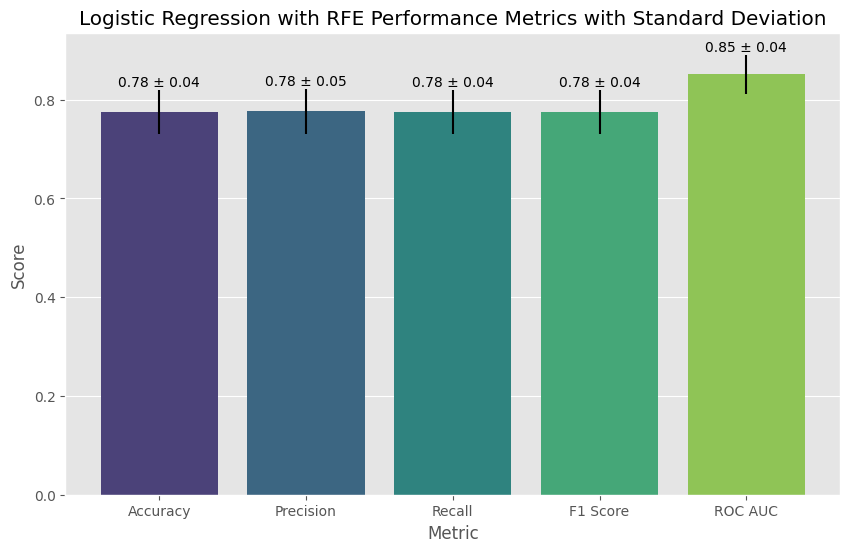

In [83]:
plot_metrics(lr_rfe_metrics_df, 'Logistic Regression with RFE')

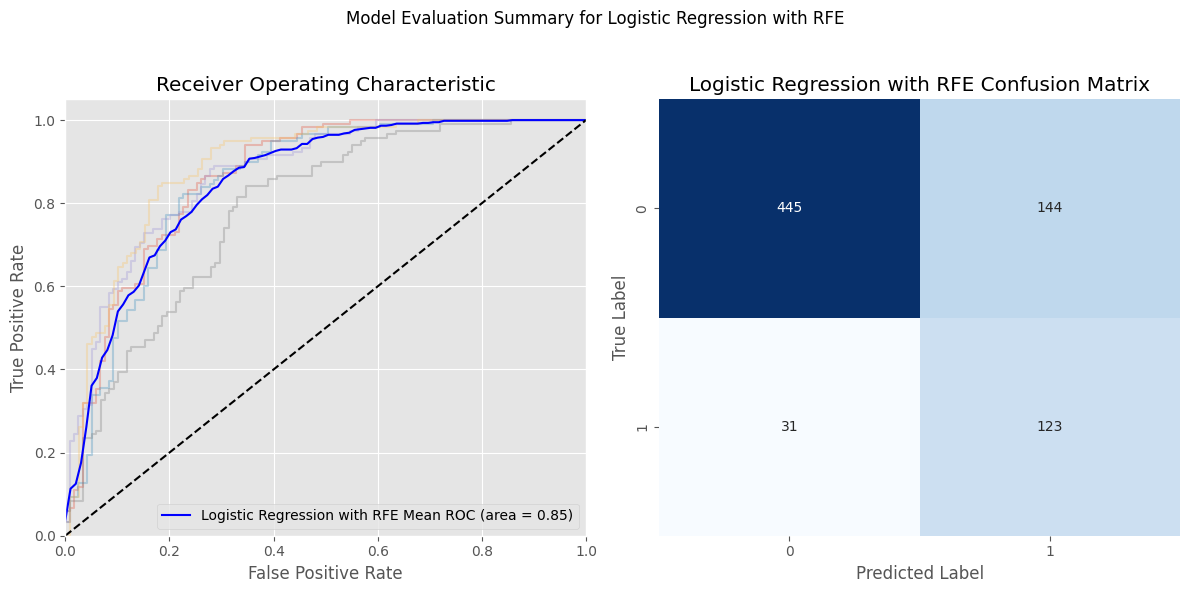

In [84]:
plot_model_evaluation_summary(lr_rfe_roc_curves, lr_rfe_metrics_df.mean(), lr_rfe_estimator, X_test, y_test, 'Logistic Regression with RFE')


The logistic regression model with RFE (20 selected features) performs comparably to the model with all variables, with a minor trade-off in the ROC AUC score (0.84 vs. 0.85). The RFE model shows a slight improvement in identifying positive cases (higher TP, lower FN) but has a marginal increase in false positives. Overall, using RFE to reduce the number of features to 20 provides a similar performance while  offering benefits in terms of model simplicity and computational efficiency so the tradeoff is barely noticable.

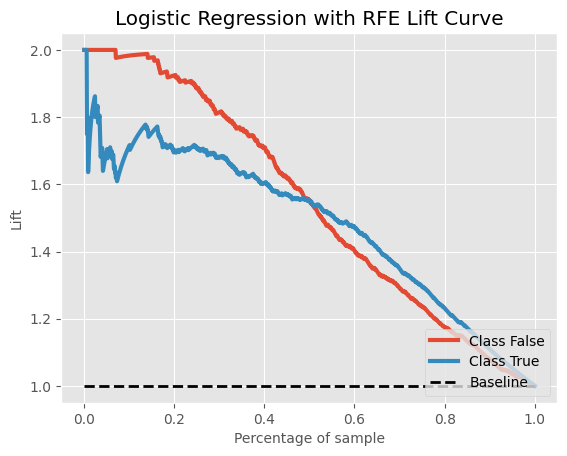

In [85]:
plot_lift_curve(lr_rfe_lift_probs, lr_rfe_true_labels, 'Logistic Regression with RFE')

The Lift Curve shows that the new proposed model is about twice as effective in classifying non-card customers as randomly guessing an outcome for 10% of the client base. At 50% of the customer base the model still is just above 1.5 times more certain at predicting if someone will buy a card or not.

## <a id='toc1_11_'></a>[Model Explanation](#toc0_)

The last step is to get a better grasp on how the model makes decisions and ultimately predictions. To dive deeper into explainability, the package `dalex` will be utilized.

First, an `Explainer` both in the context of the train split and the test split is created. As explained in the paper [DO NOT EXPLAIN WITHOUT CONTEXT: ADDRESSING THE BLIND SPOT OF MODEL EXPLANATIONS](https://arxiv.org/pdf/2105.13787) it makes sense to look at all splits since for example Partial Dependence Plots not only convey information about the model but also the underlying data these models were trained on.

Since `dalex` unfortunately is still in development for Python some bugs emerge. For example, when trying to work with an sklearn `Pipeline`, `dalex` has difficulties transforming the data and displaying the correct feature names for its plots - Hence the process below first shows a rather laborious way of transforming the selected features through all pipeline steps and then passing the estimator and transformed data to the `Explainer`. Since `dalex` expects barebone sklearn estimators (not wrapped in a `Pipeline`) an error was thrown repedeatly for every feature; This is why the warnings at this point get suppressed to not clutter the notebook.

In [86]:
warnings.filterwarnings("ignore")

X_train_rfe_prep = lr_rfe_estimator.named_steps['preprocessor'].transform(X_train[all_vars_column_selection.columns])
X_train_rfe_selected_cols = lr_rfe_estimator.named_steps['rfe'].transform(X_train_rfe_prep)
X_train_rfe_selected_cols = pd.DataFrame(X_train_rfe_selected_cols, columns=rfe_selected_columns)

X_test_rfe_prep = lr_rfe_estimator.named_steps['preprocessor'].transform(X_test[all_vars_column_selection.columns])
X_test_rfe_selected_cols = lr_rfe_estimator.named_steps['rfe'].transform(X_test_rfe_prep)
X_test_rfe_selected_cols = pd.DataFrame(X_test_rfe_selected_cols, columns=rfe_selected_columns)

test_explainer = Explainer(lr_rfe_estimator.named_steps['classifier'], X_test_rfe_selected_cols, y_test, label='Reduced Logistic Regression (test set)')
train_explainer = Explainer(lr_rfe_estimator.named_steps['classifier'], X_train_rfe_selected_cols, y_train, label='Reduced Logistic Regression (train set)')

Preparation of a new explainer is initiated

  -> data              : 743 rows 20 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 743 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Reduced Logistic Regression (test set)
  -> predict function  : <function yhat_proba_default at 0x29c922ca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00139, mean = 0.393, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.992, mean = -0.186, max = 0.969
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1186 rows 20 cols
  -> target variable   : Parameter 'y' was a pandas.

### <a id='toc1_11_1_'></a>[Evaluation Metrics](#toc0_)

To get a first glance at the performance metrics on the model, the following block displays the `model_performance()`.

In [101]:
model_performance = pd.concat([train_explainer.model_performance().result, test_explainer.model_performance().result])
model_performance

recall  precision        f1  \
Reduced Logistic Regression (train set)  0.806071   0.784893  0.795341   
Reduced Logistic Regression (test set)   0.798701   0.460674  0.584323   

                                         accuracy       auc  
Reduced Logistic Regression (train set)  0.792580  0.874579  
Reduced Logistic Regression (test set)   0.764468  0.854001

We have already seen the performance metrics on the Train Set when the model was trained before. The test set however now shows a much lower precision and therefore also a lower F1 score. This however may just be due to the fact that the test set stayed untouched in terms of class distribution.

### <a id='toc1_11_2_'></a>[Variable Importance](#toc0_)

Now we take a look at the variable importance (dropout loss) for the remaining top variables.

In [104]:
mp_lg_train = train_explainer.model_parts(type='variable_importance')
mp_lg_test = test_explainer.model_parts(type='variable_importance')

mp_lg_train.plot(mp_lg_test)

For both sets the same 8 first variables show roughly the same dropout loss. After these the variable importance changes between the both sets: 
- Within the Train Set the number of transactions before card issuance and the account age seem to play a bigger role than for the Test partition.
- Within the Test partition the number of transactions in the first month of the rollup window and the withdrawal happening in the 9th month before issuance play a larger role.

### <a id='toc1_11_3_'></a>[Partial Dependence](#toc0_)

Each following subplot shows the partial dependence for both the train set (green line) and the test set (blue line). The Partial Dependence shows the consistency of the model's learned relationships across both datasets for the reduced Logistic Regression model. The PDPs can show how changes in each variable, while keeping others constant, influence the predicted outcome.

In [134]:
pd_lr_train = train_explainer.model_profile(center='mean')
pd_lr_test = test_explainer.model_profile(center='mean')

pd_lr_train.plot(pd_lr_test)

Calculating ceteris paribus: 100%|██████████| 20/20 [00:00<00:00, 171.77it/s]


Both within the test and train partition the Partial Dependence for all features seems to have very similar structure. Most variables show a linear trend, however the variables `credit_month_mean` (Mean of Credit amount during the Rollup Window) and `credit_month_sum` (Sum of Credit amount during the Rollup Window) show a more squished together sigmoid function where high credit statistics lead to a more likely prediction of `1` (`has_card=True`). The `volume`-related statistics (except for `pre_card_volume_min`) on the other hand, show the opposite: The higher the `volume` stats, the less likely the model is to predict a customer having a card.

### <a id='toc1_11_4_'></a>[Variable Attribution](#toc0_)

In [129]:
account_ids = [14, 18]

selected_clients = client_df[client_df['account_id'].isin(account_ids)]

for account_id in account_ids:
    client = selected_clients[selected_clients['account_id'] == account_id]
    
    va_expl = train_explainer.predict_parts(client[rfe_selected_columns], type='shap', label=f'Account {account_id}')
    
    va_expl.plot()

Comparing the SHAP plots for Account 14 and Account 18, we can observe distinct differences in the feature contributions. For Account 14, the largest negative contributor is `volume_month_sum` (-0.797), while for Account 18, it is also `volume_month_sum` (-0.52), but with a slightly lesser impact. Both accounts see significant positive contributions from `volume_month_diff_7` (+0.297 for Account 14) and `volume_month_mean` (+0.32 for Account 18). Additionally, Account 18's positive contributions are more distributed, with `credit_month_sum` and `volume_last_quarter_std` also playing significant roles, while Account 14 has fewer strongly positive features. Overall, Account 18 has a more balanced distribution of feature impacts compared to Account 14.

## <a id='toc1_12_'></a>[Conclusive Value of the Final Model](#toc0_)

The final card purchase prediction model shows meaningful improvement for targeting potential buyers. The results show that for the top 20% of the customer sample, the success rate can almost be doubled compared to a 50/50 baseline. By focusing on the key factors like transaction volume and credit amounts, more precise market strategies can be launched.

In short, the new model shows appropriate robustness that will improve the banks ability to connect with the right customers with the right card offers.